In [1]:
import os   #used for directory work
import matplotlib.patches as mpatches #used for plot legends
import matplotlib.pyplot as plt #used for creating plots
import matplotlib.cm as cm
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/" #79 location
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/"  #134 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/" #w10 location
def text_finder(path):
    txt_files=[]
    all_files = os.listdir(path) #tells what directory the files are in
    for i in all_files: #reading only the .txt files 
        if i[-4:] == ".txt":
            txt_files.append(i)
    txt_files.sort() #alphabetizes them
    return txt_files

#txt_files = text_finder(path)
#df = pd.read_csv(path + txt_files[0],na_values = ['NAN', "00nan"], sep="\t")  



In [3]:

def calculations(df,n):
    timestamp_lst, speed = [],[]
    for t in range(len(df)):
        timestamp_lst.append(pd.Timestamp(str(df["YYYY"][t])+"-"+str(df["MM"][t])+"-"+str(df["DD"][t]) +" "+str(df["Hr"][t])+":"+str(df["Min"][t])+":"+str(df["Sec"][t]),freq = ".1S"))
        speed.append(np.sqrt((df["U"][t])**2+(df["V"][t])**2))

    df_raw = pd.DataFrame()
    df_raw["Timestamp"] = timestamp_lst
    df_raw["W"]=df["W"]
    df_raw["S"]=speed
    df_raw["T"]= df["T"]


    #### Calculating the W', S' averages

    W_average = np.mean(df["W"][:n])
    S_average = np.mean(df_raw["S"][:n])

    W_prime, S_prime= [], []
    for i in range(len(df)):
        W_prime.append(df["W"][i]-W_average)
        S_prime.append(df_raw["S"][i]-S_average)

    ### Making the Quad list for all the points
    quad = [] 
    for i in range(len(df_raw)):
        if float(W_prime[i]) > 0 and float(S_prime[i]) > 0:
            quad.append(1)
            continue
        if float(W_prime[i]) > 0 and float(S_prime[i]) < 0:
            quad.append(2)
            continue
        if float(W_prime[i]) < 0 and float(S_prime[i]) < 0:
            quad.append(3)
            continue
        if float(W_prime[i]) < 0 and float(S_prime[i]) > 0:
            quad.append(4)
            continue
        else:
            quad.append(0)


    df_raw["Quad"] = quad
    df_raw = df_raw.set_index("Timestamp")
    time_steps = "10s"

    n_per_10s=list(df_raw.resample(time_steps).count()["W"])

    counter = 0
    q1_list, q2_list = [], []
    q3_list, q4_list = [], []
    for a in n_per_10s:
        if a ==0:
            q1_list.append(0)
            q2_list.append(0)
            q3_list.append(0)
            q4_list.append(0)
            continue
        else:
            q1_list.append((1*quad[counter:int(a+counter)].count(1))/a)
            q2_list.append(-1*(quad[counter:int(a+counter)].count(2))/a)#
            q3_list.append((1*quad[counter:int(a+counter)].count(3))/a)
            q4_list.append(-1*(quad[counter:int(a+counter)].count(4))/a)#

            counter = counter + int(a)

    missing = []
    for i in  range(len(q1_list)):
        percentage= q1_list[i]-q2_list[i]+q3_list[i]-q4_list[i]
        missing.append(round(1-percentage,6))
    
    q3_bottom = []
    for i in range(len(q1_list)):
        q3_bottom.append(missing[i]+q1_list[i])
    
    ## W'S' 
    ws = []
    for i in range(len(df)):
        ws.append(W_prime[i]*S_prime[i])

    df_prime = pd.DataFrame()
    df_prime["Timestamp"] = timestamp_lst
    df_prime["W'S'"]= ws
    df_prime = df_prime.set_index("Timestamp")

    df_plot = df_prime.resample(time_steps).mean()

    x_tick_loc, x_tick_label = [], []
    for i in range(0,len(df_plot),len(df_plot)//5):
        x_tick_loc.append(i)
        x_tick_label.append(str(df_plot.index[i])[-9:])

    x = np.arange(0, len(q1_list), 1)
    
    #Calculating the time of fire for each sonic
    T_resample = list(df_raw.resample(time_steps).mean()["T"])
    x_fire = 0
    for i in range(len(T_resample)):
        if T_resample[i] > (np.mean(T_resample)+5*np.std(T_resample)):
            x_fire = i+.5 
            break

    return x,x_fire, df_plot, missing,q1_list, q2_list, q3_list, q4_list,x_tick_loc, x_tick_label,q3_bottom

In [4]:
def grid(path,n,burn,seperator = " "):

    fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(28,16))
    y_tick_loc = [-1,-.75,-.5,-.25,0,.25,.5,.75,1]
    y_tick_label = [100,75,50,25,0,25,50,75,100]
    txt_files = text_finder(path)
    file=0
    for col in range(4):
            for row in range(4):
                #read in the data and compute means
                df = pd.read_csv(path + txt_files[file],na_values = ['NAN', "00nan"], sep=seperator)  
                x,x_fire,df_plot,nan_list, q1_list, q2_list, q3_list, q4_list,x_tick_loc, x_tick_label, q3_bottom= calculations(df,n)
                
                #Plotting nums
                ax1 = axs[ col, row]
                ax1.bar(x,q2_list, color = "indianred", label = " II (Ejection)", alpha = .75 )
                ax1.bar(x,q3_list, color = "orange", label = "III (Inward Int.)", bottom = q3_bottom, alpha = .7)#,bottom= q3_bottom)
                ax1.bar(x,q1_list, color = "limegreen", label = "I (Outward Int.)", alpha = .5, bottom = nan_list)
                ax1.bar(x,q4_list, color = "royalblue" , label = "IV (Sweep)",bottom = q2_list, alpha = .6)#bottom = q4_bottom)
                ax1.bar(x,nan_list, color = "c",label = "Missing" )
                
                #Vertical lines 
                ax1.vlines(n/100-.5, -1,1 , color = "k",label =r"$\overline{PreBurn}$", linestyle = "--",linewidth = .5)
                ax1.vlines(x_fire, -1 ,1, color = "darkred",label ="($T{}'$ $+5\sigma$)", linestyle = "--",linewidth = .5)
                ax1.set_xlim(0, len(q1_list))
                ax1.set_yticks(y_tick_loc)
                ax1.set_yticklabels(y_tick_label)
                h, l = ax1.get_legend_handles_labels()
                ax1.legend(h[2:], l[2:],ncol = 3,loc = 'lower center', bbox_to_anchor=(0.38, -.32), fontsize = 9,framealpha=0.5, markerscale = .7)
                ax1.set_title(txt_files[file][:2], fontsize = 14)
                
                ax1.set_xlabel('Time (EST)',fontsize=9, position=(.94,0.4))
                ax1.set_ylabel('% of Events ', color="k")
                ax1.tick_params(axis='y', labelcolor="k")
                ax1.set_ylim(-1,1)
                ax1.set_xticks(x_tick_loc)
                ax1.set_xticklabels(x_tick_label)
                
                ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylabel(r"S${}'$W${}' (\frac{{m}^2}{{s}^2})$", color="k")  
                ax2.scatter(x,df_plot["W'S'"], c = "k", s = 2,label = r"S${}'$W${}'$")
                ax2.set_ylim(-2,2)
                h2, l2 = ax2.get_legend_handles_labels()
                ax2.legend(h2, l2,ncol = 2,loc = 'lower center', bbox_to_anchor=(0.72, -.32), fontsize = 9,frameon=False, markerscale = .7)
               
                file=file+1 #used to change the files
                
    fig.subplots_adjust(hspace=.45,wspace=.3)       
    fig.suptitle(burn+' Percent Quadrant Analysis of Momentum Flux', fontsize = 22, x=0.5, y=0.92)
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles[:2], labels[:2], loc= 'upper right',bbox_to_anchor=(.85, .94),ncol = 3, fontsize = 20)
    fig.savefig(burn+"_Percent-Momentum-Flux-Grid.png",dpi=450)
   
    

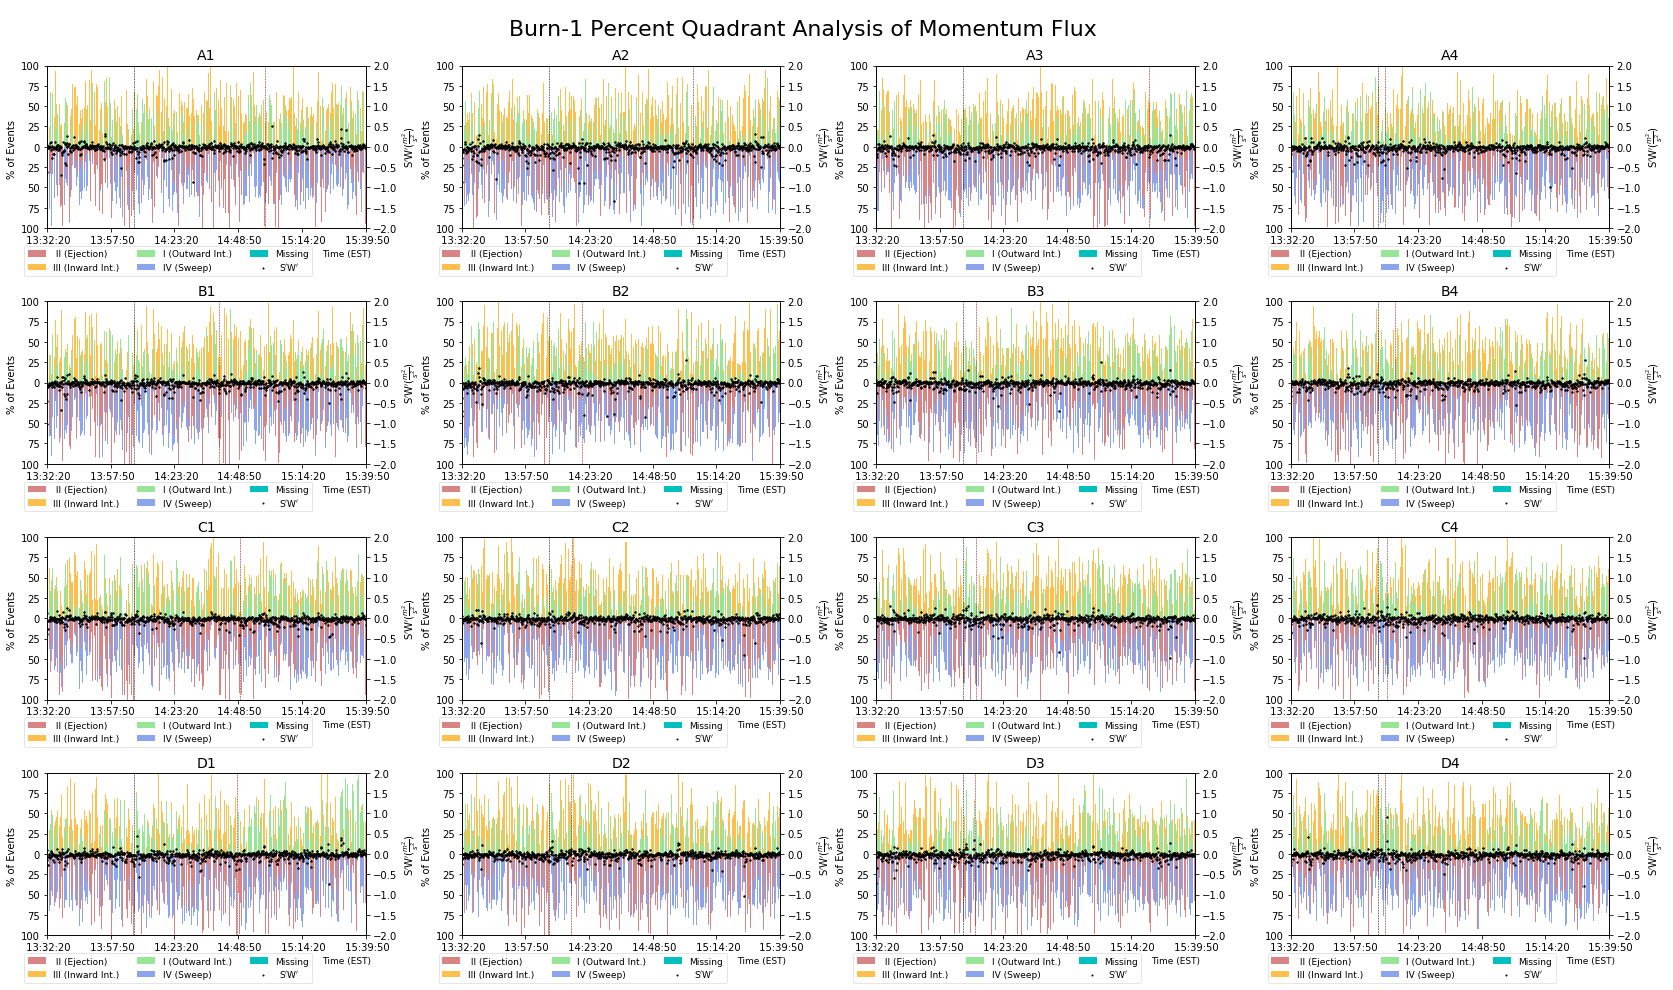

In [6]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-1/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-1/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-1/sonics/"  #134 location

grid(path,21000,"Burn-1")

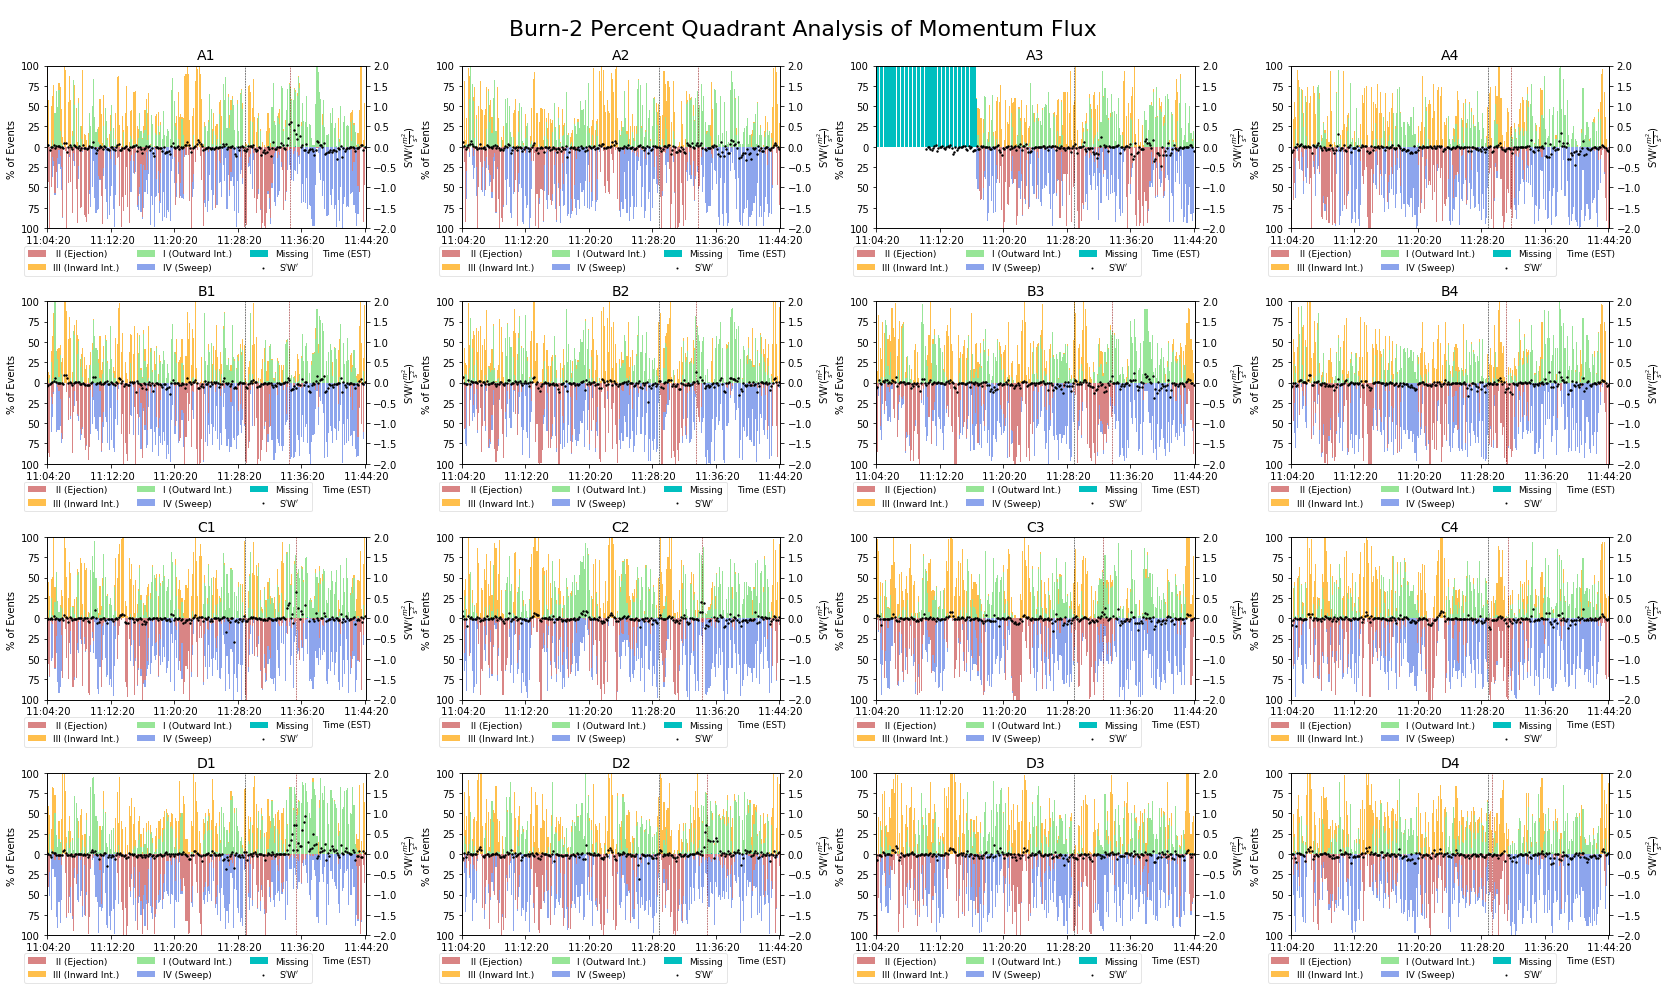

In [7]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-2/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-2/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/"  #134 location
grid(path, 15000,"Burn-2")

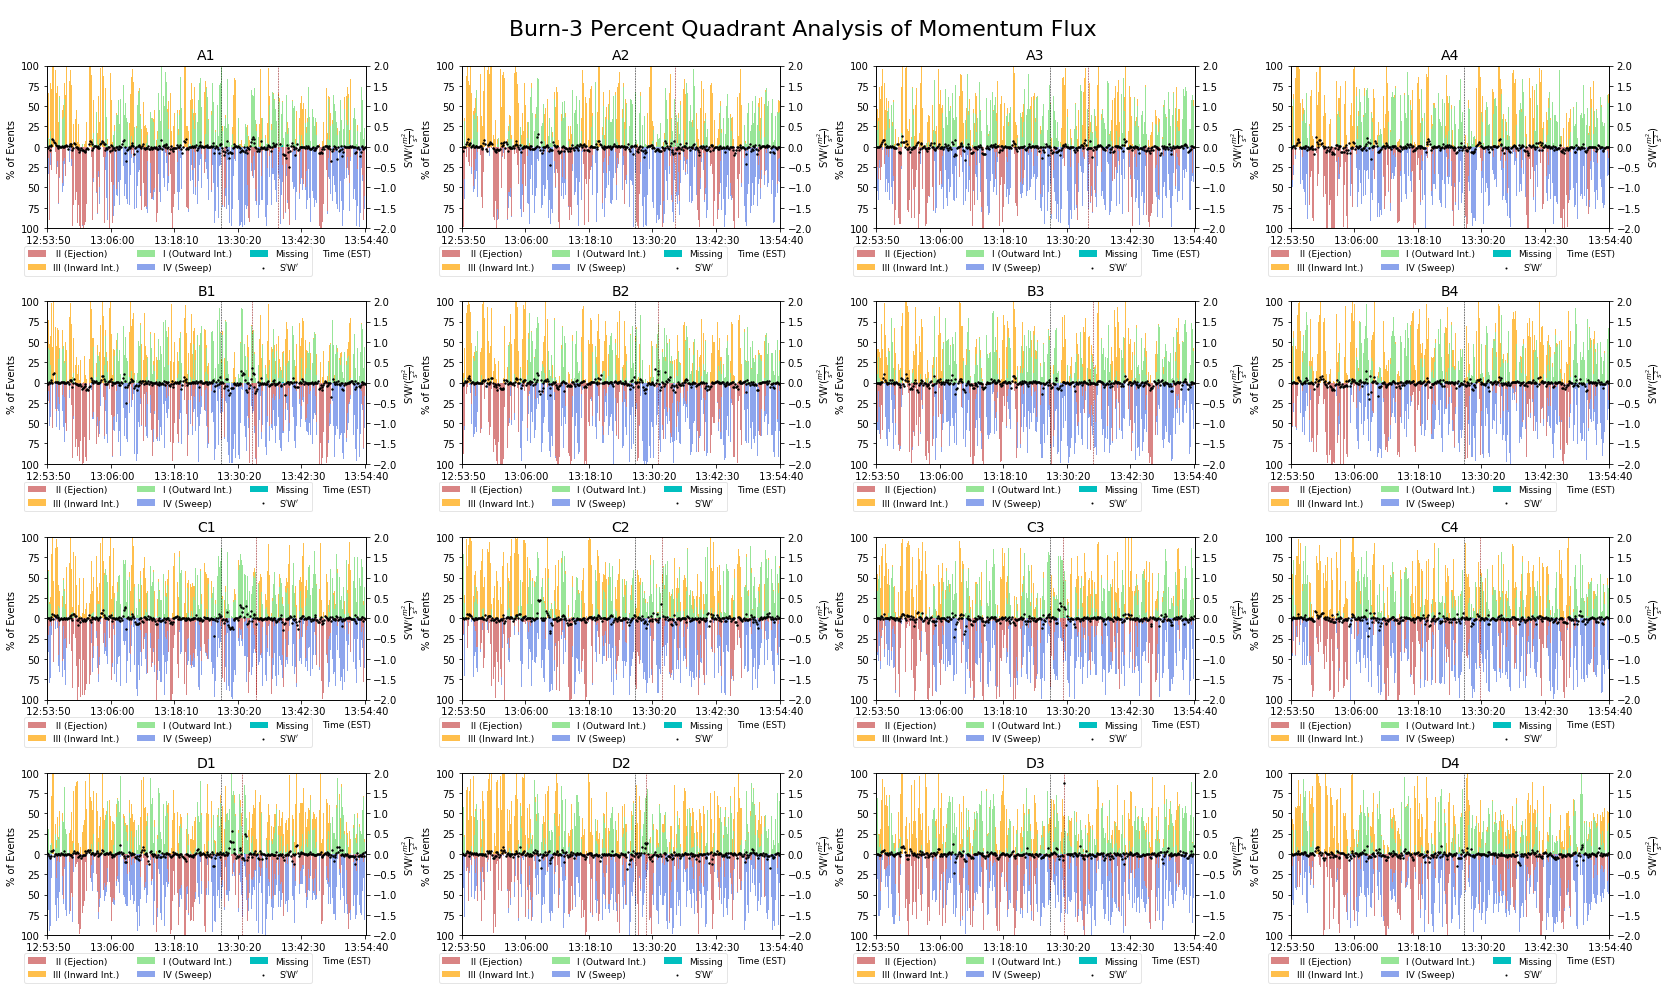

In [8]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-3/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-3/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-3/sonics/"  #134 location

#grid(path,20000,"Burn-3",True,seperator ="\t")
grid(path,20000,"Burn-3")

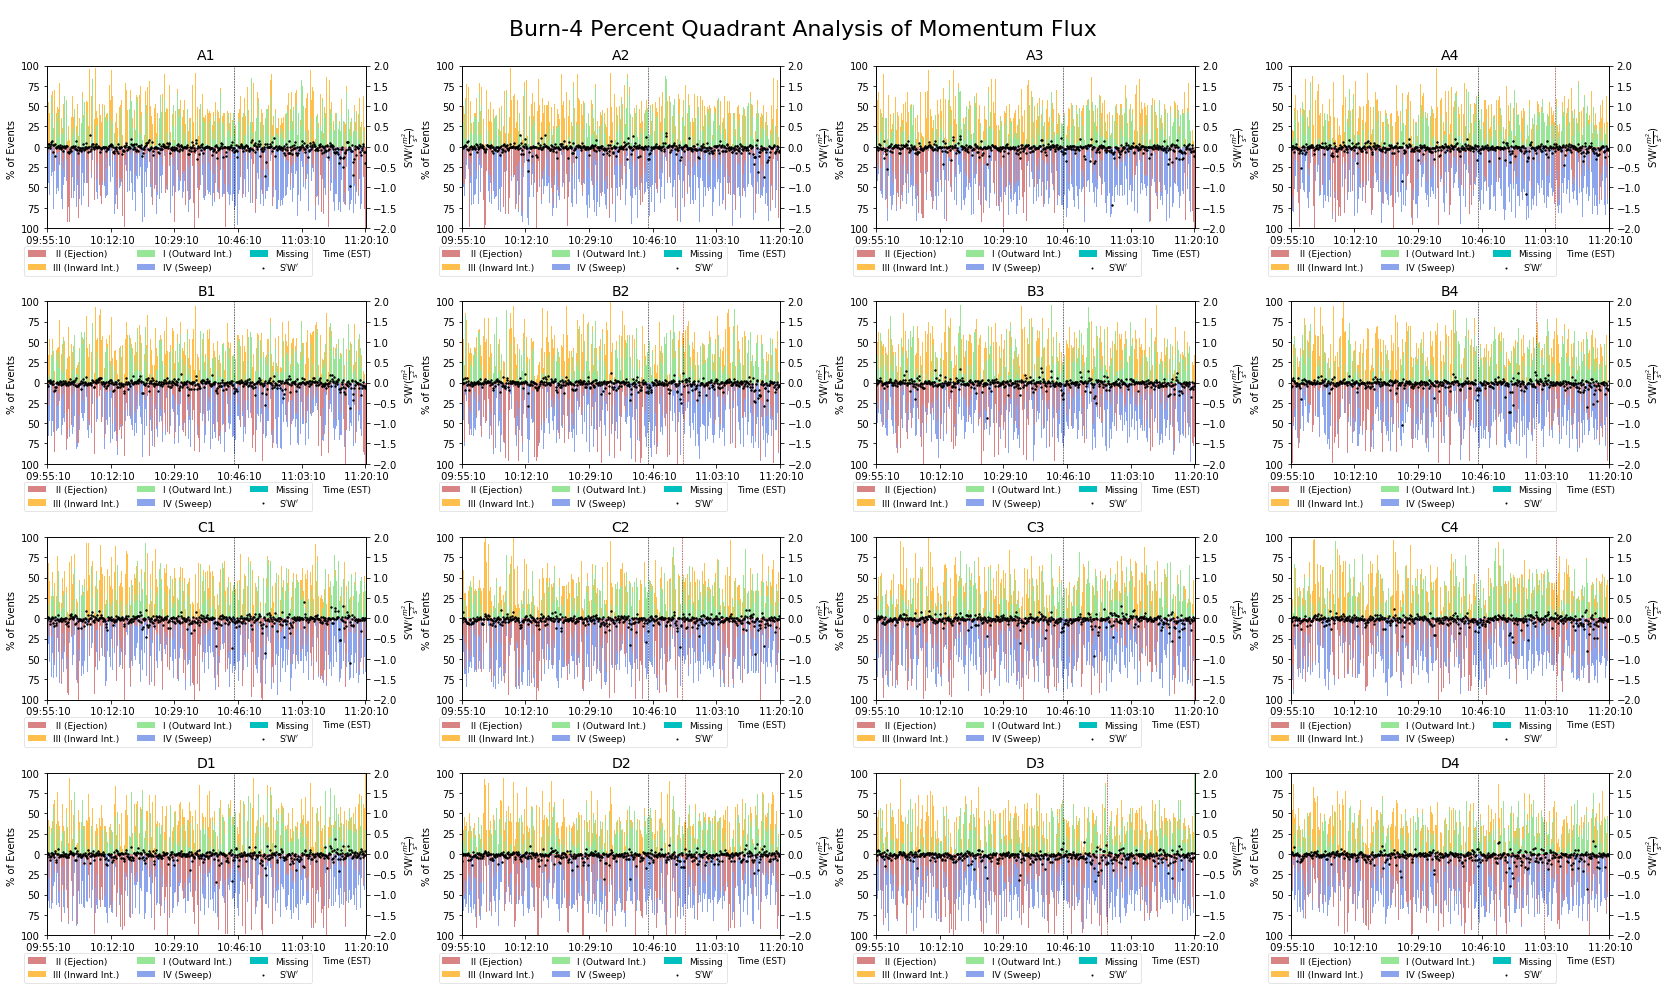

In [9]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-4/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-4/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-4/sonics/"  #134 location

#grid(path,30000,"Burn-4",True,seperator ="\t")
grid(path,30000,"Burn-4")

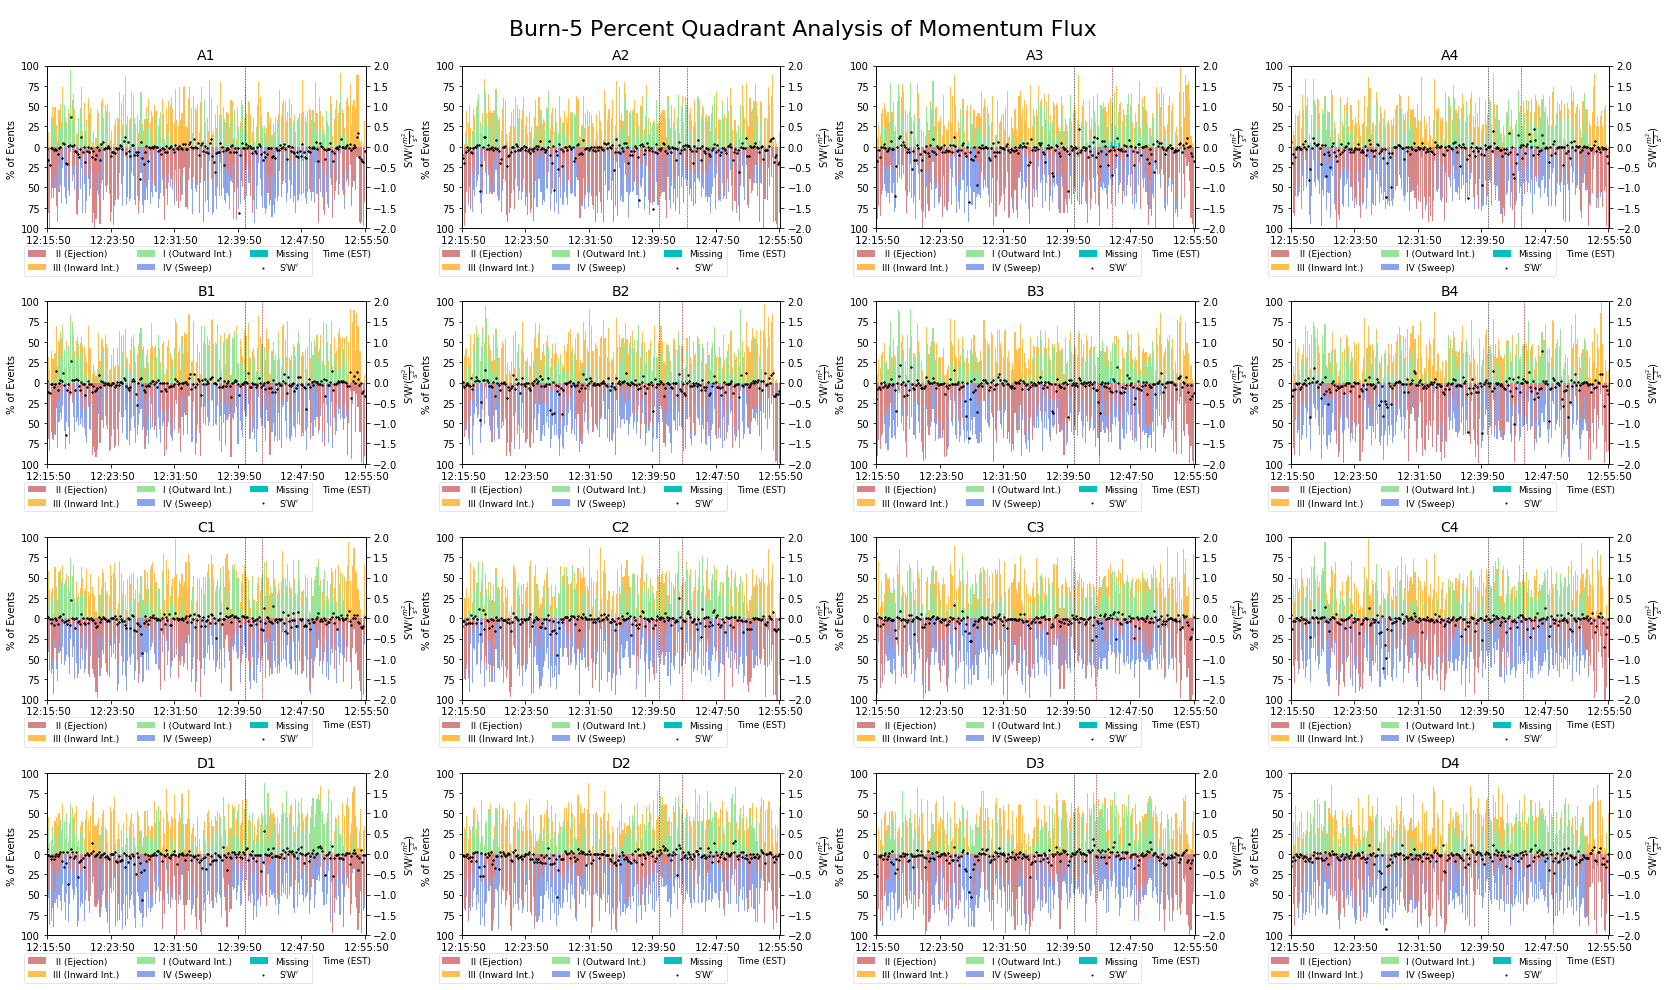

In [10]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-5/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-5/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-5/sonics/"  #134 location

grid(path,15000,"Burn-5")

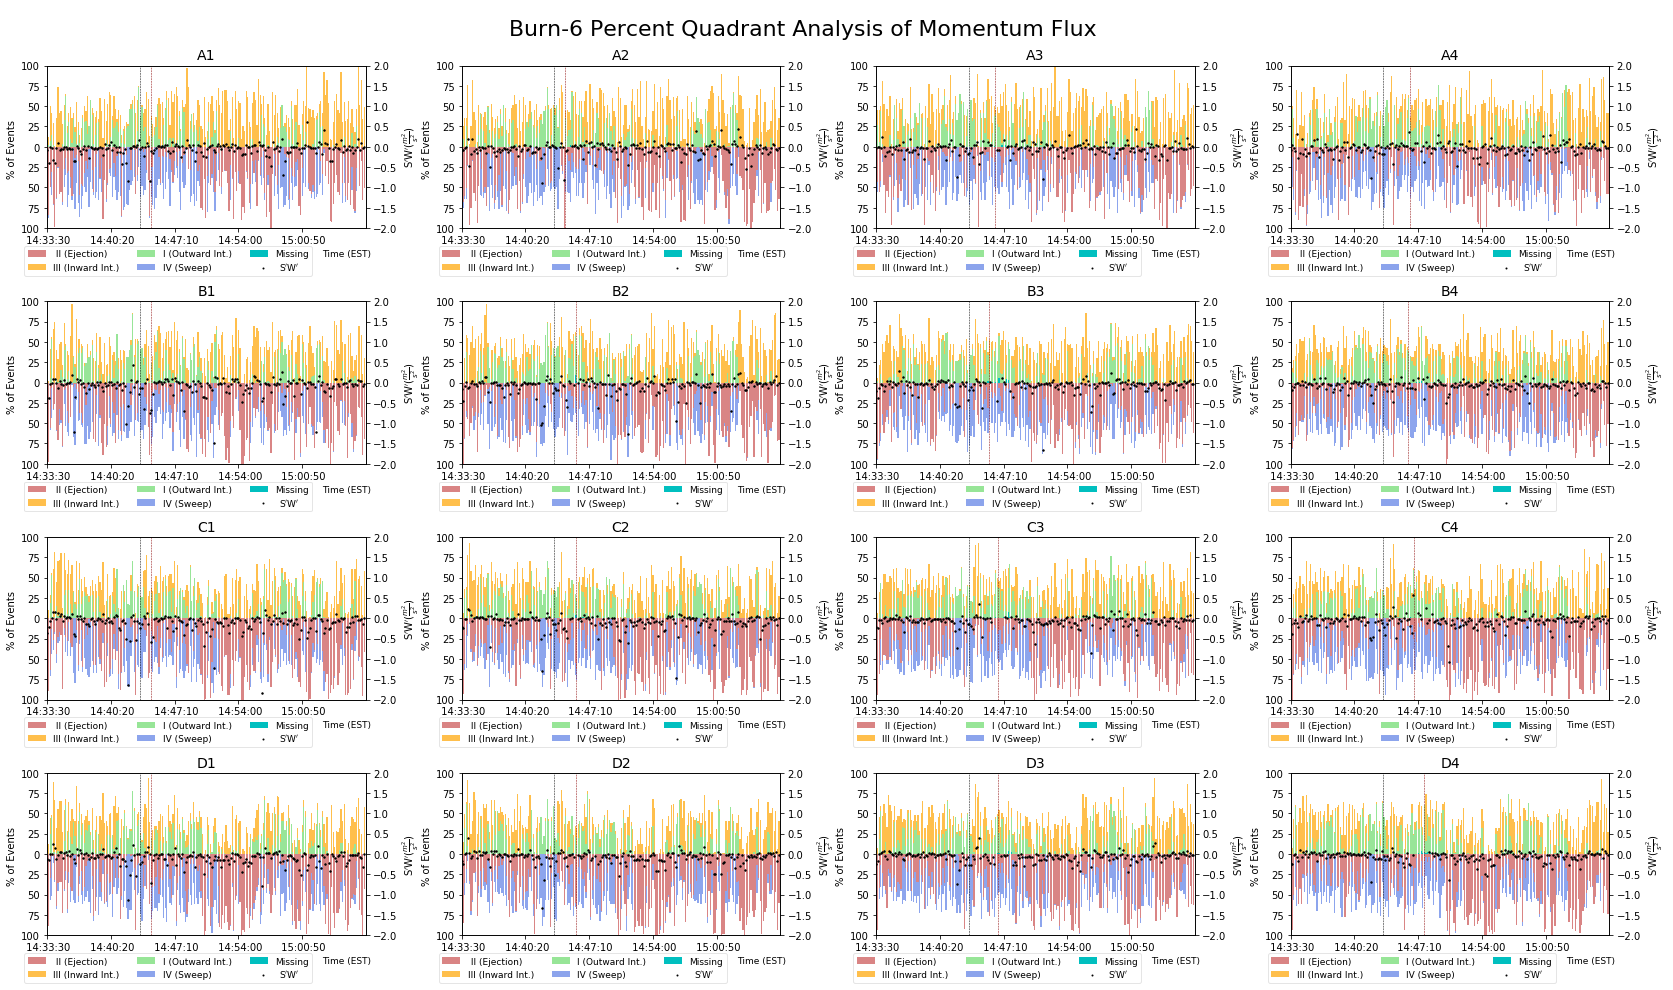

In [11]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-6/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-6/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-6/sonics/"  #134 location

grid(path,6000,"Burn-6")

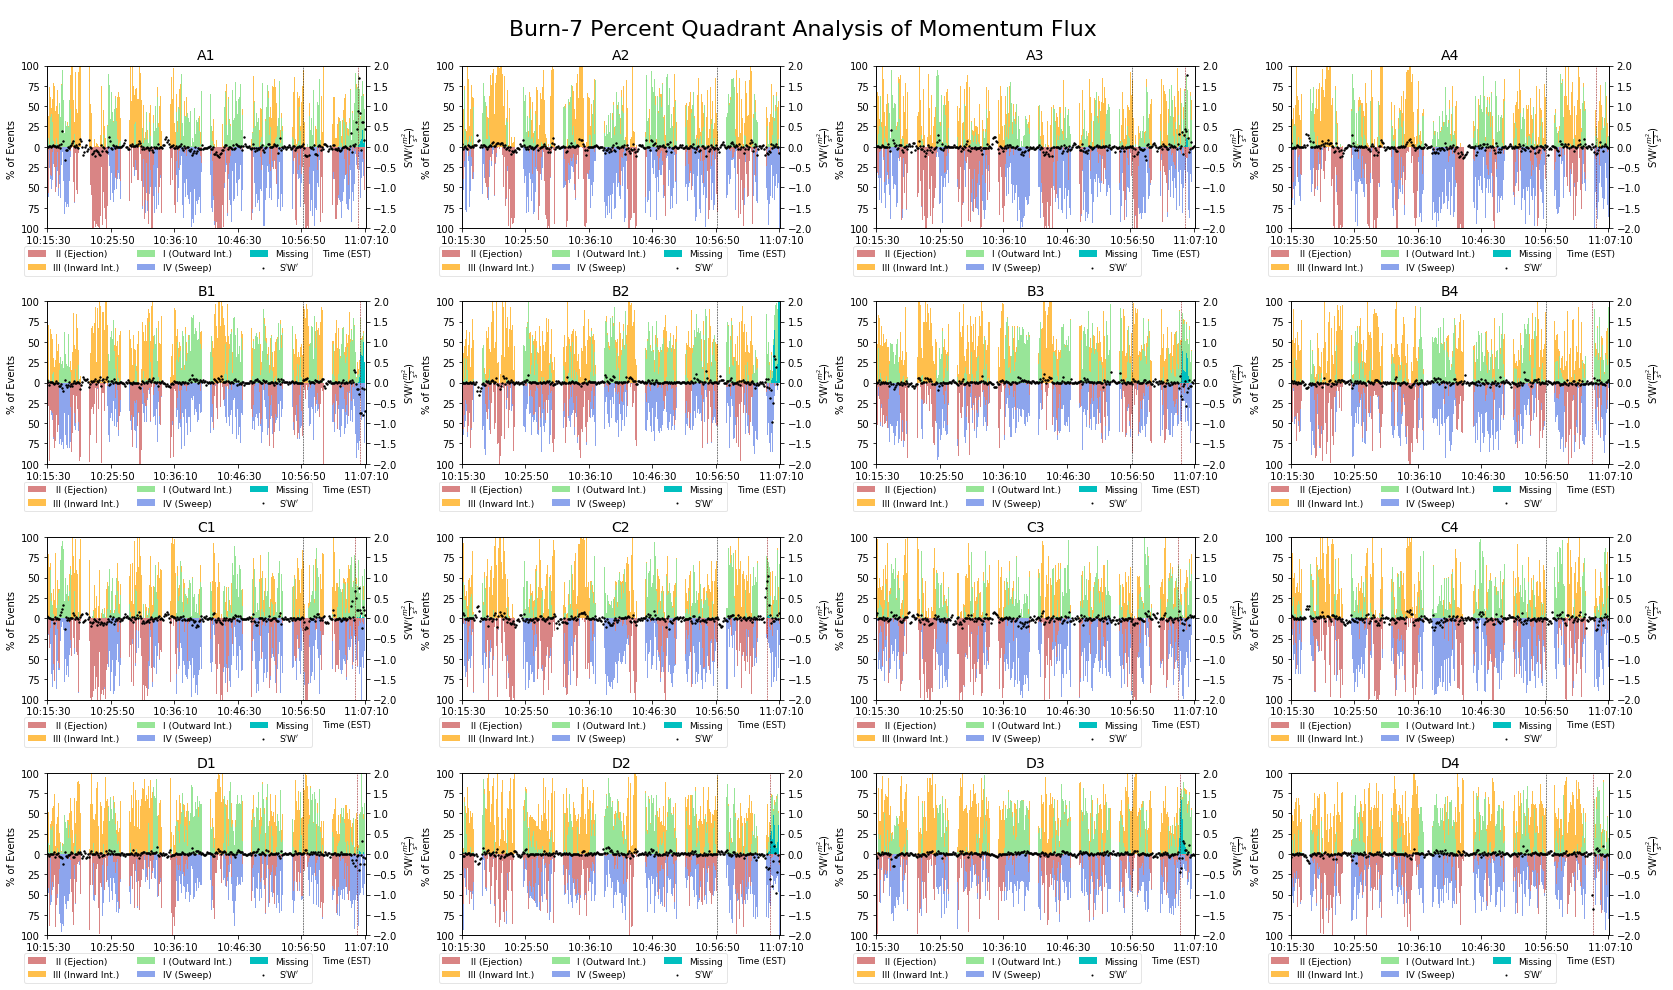

In [12]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-7/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-7/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-7/sonics/"  #134 location

grid(path,25000,"Burn-7")

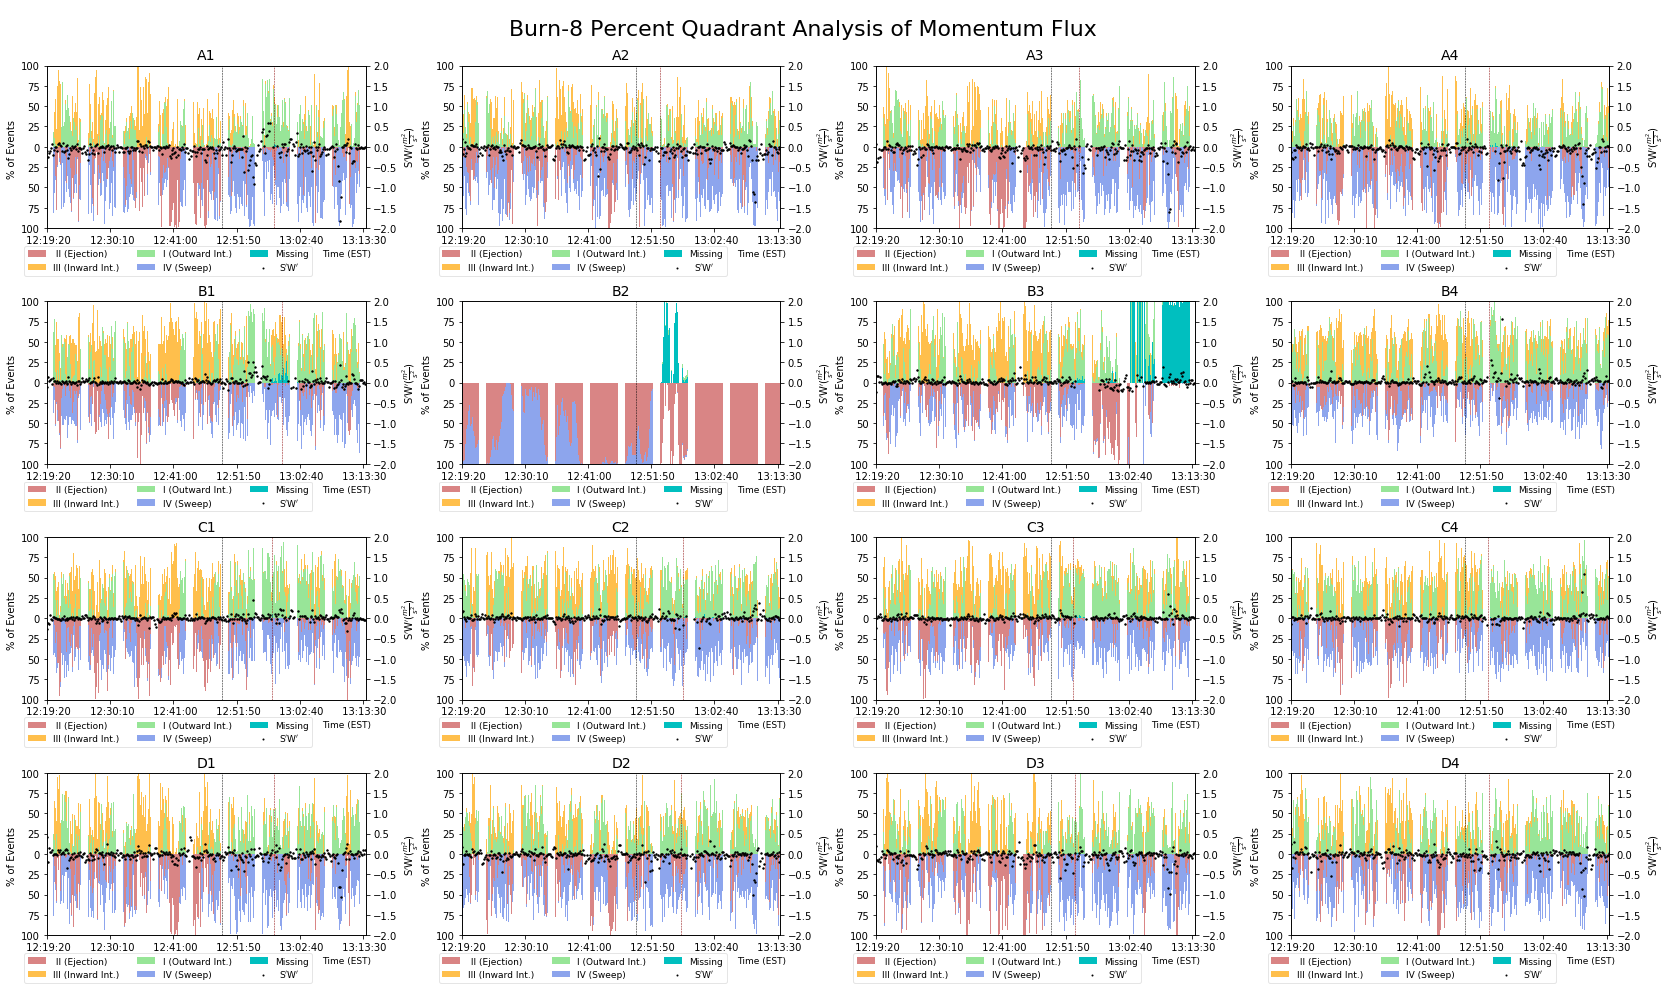

In [13]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-8/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-8/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-8/sonics/"  #134 location

grid(path,18000,"Burn-8")

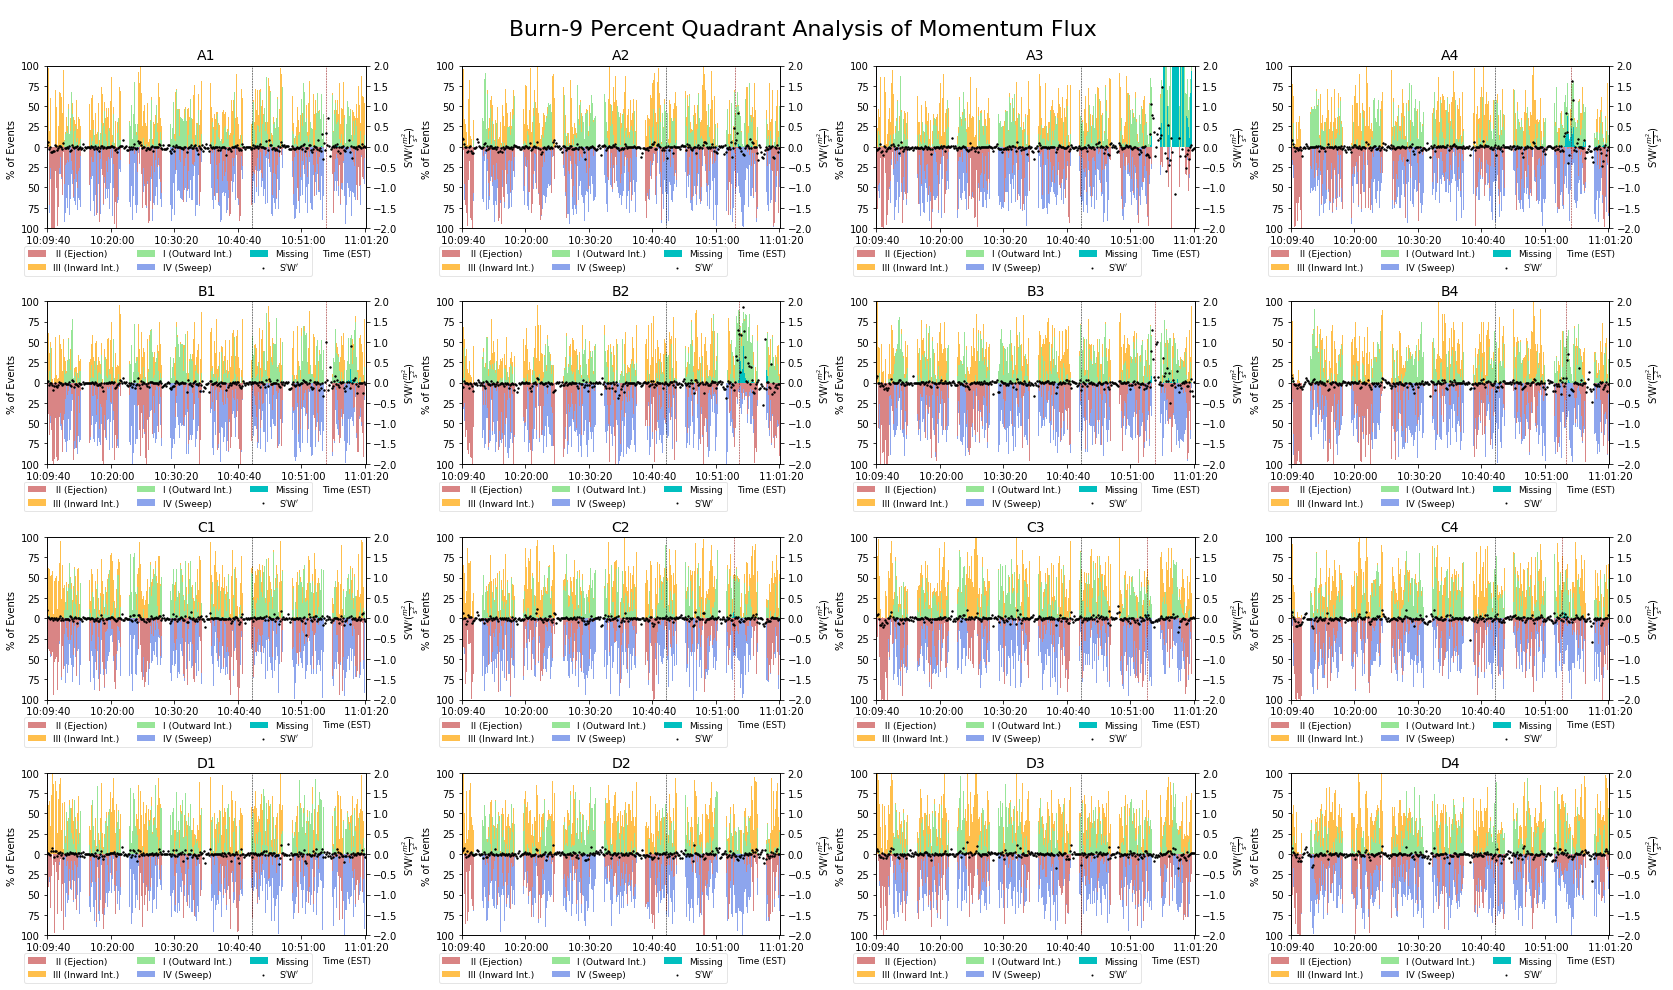

In [5]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Split-Times/Burn-09/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-9/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-9/sonics/"  #134 location

grid(path,20000,"Burn-9")#,seperator ="\t")

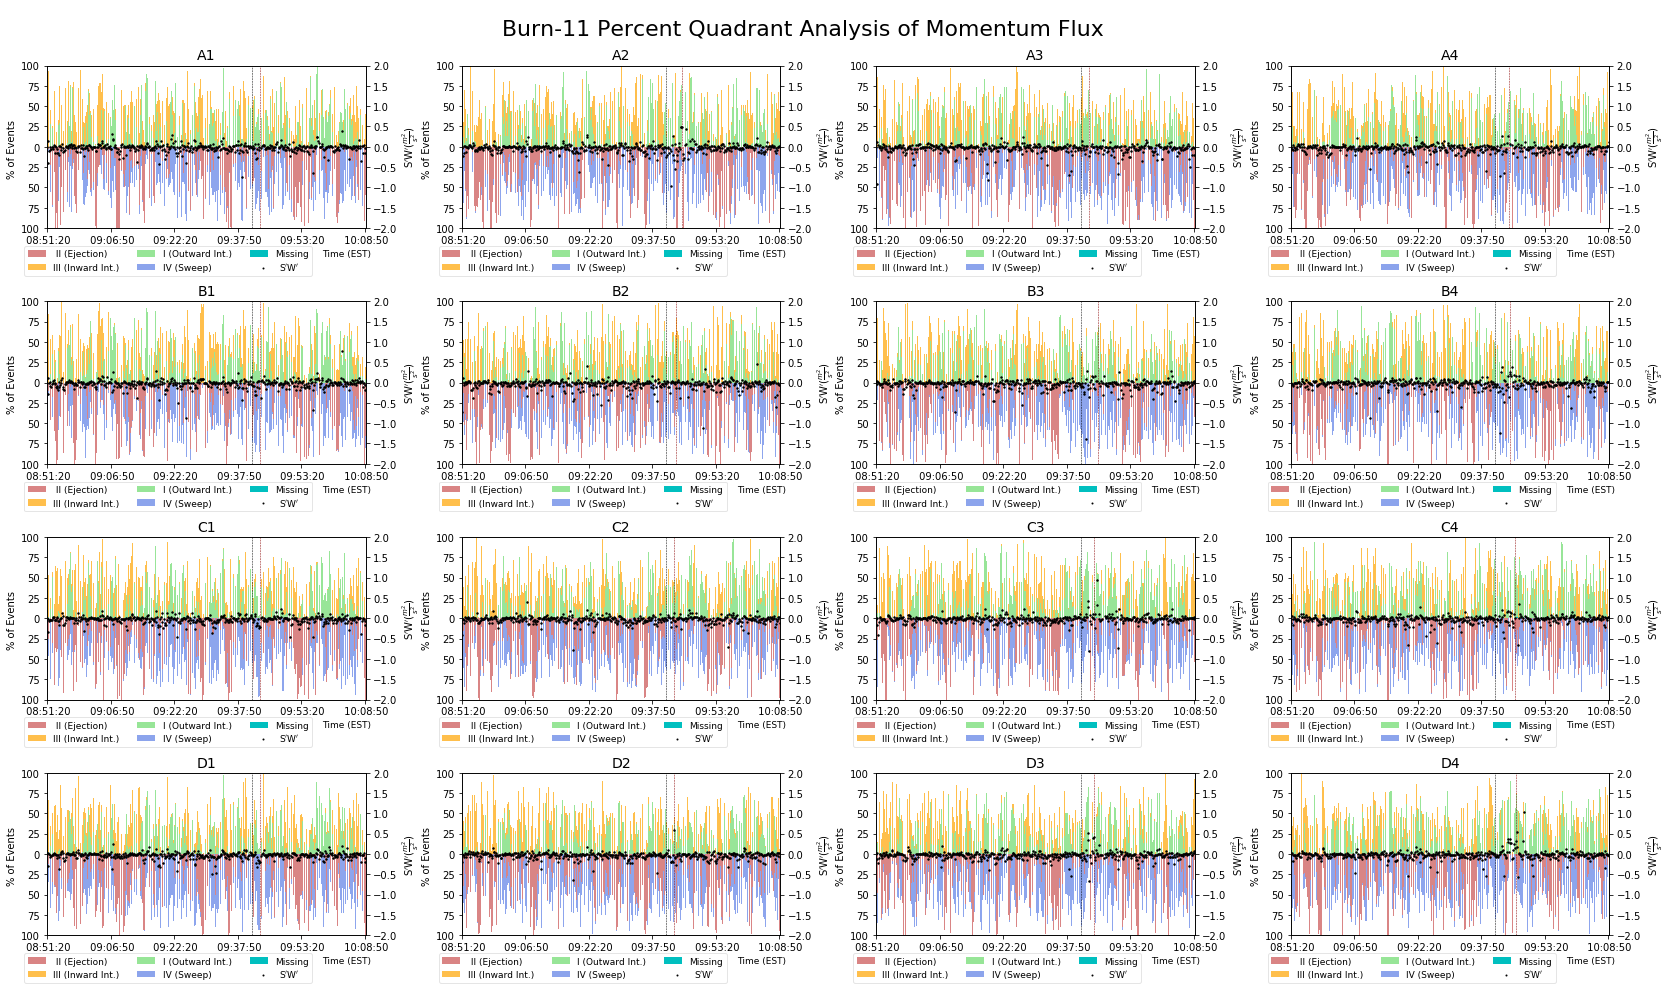

In [15]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-11/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-11/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-11/sonics/"  #134 location

grid(path,30000,"Burn-11")

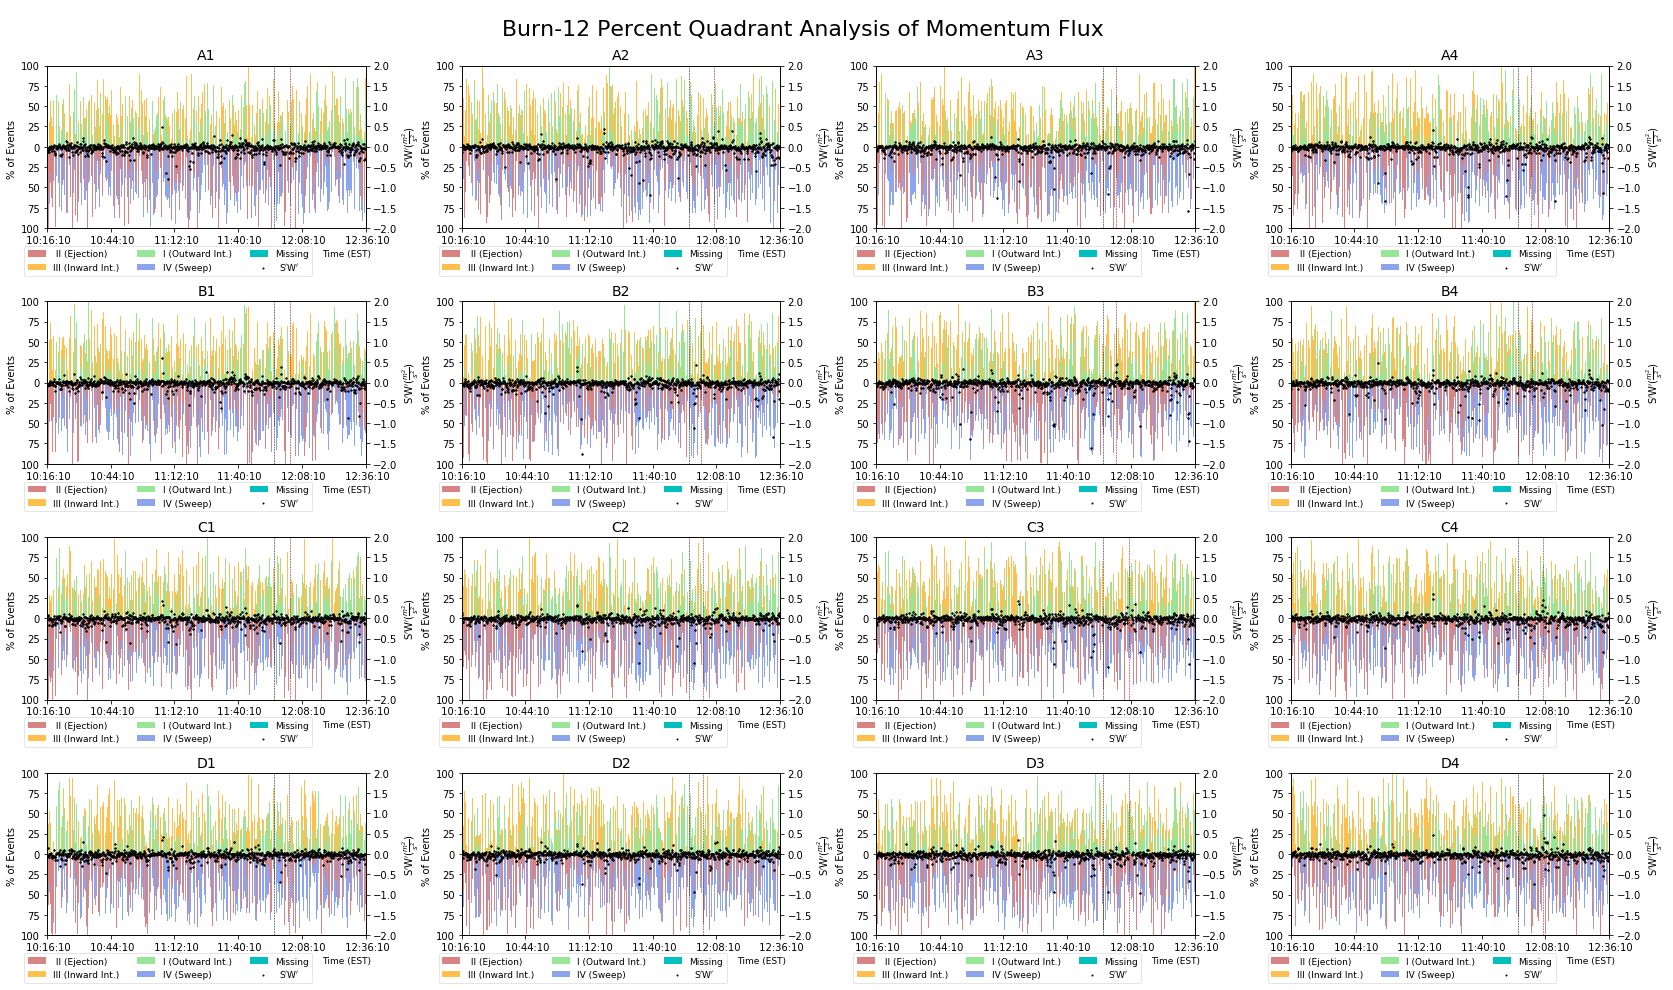

In [16]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-12/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-12/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-12/sonics/"  #134 location

grid(path,60000,"Burn-12")

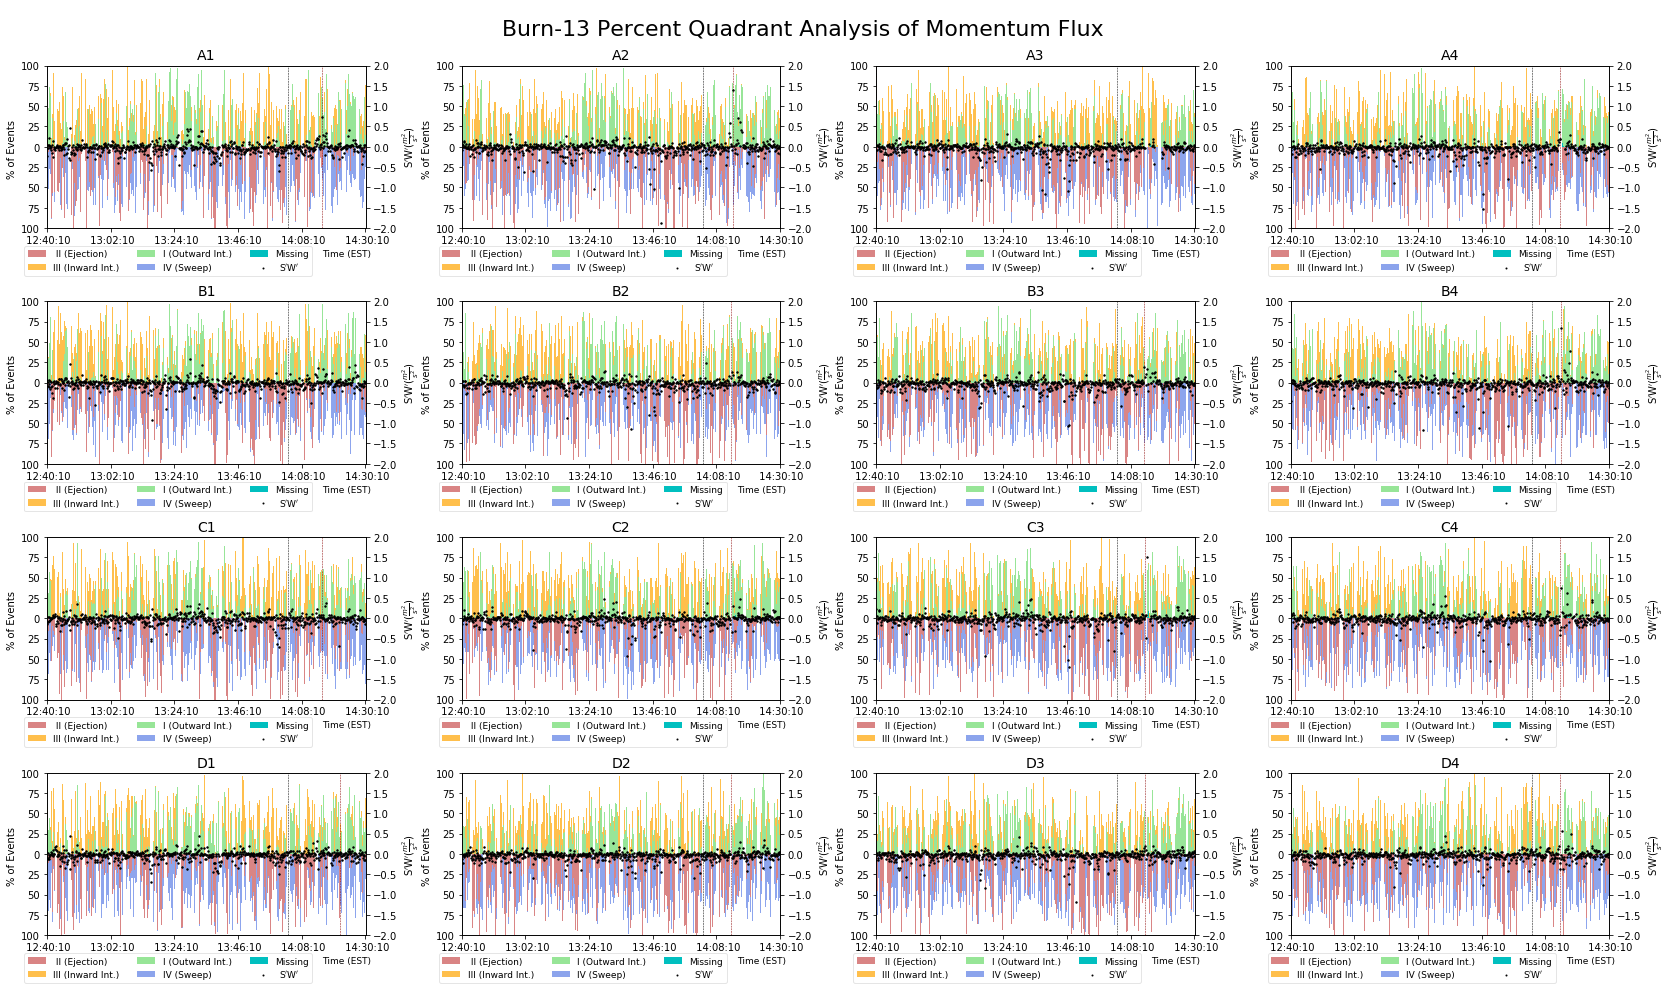

In [17]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,50000,"Burn-13")

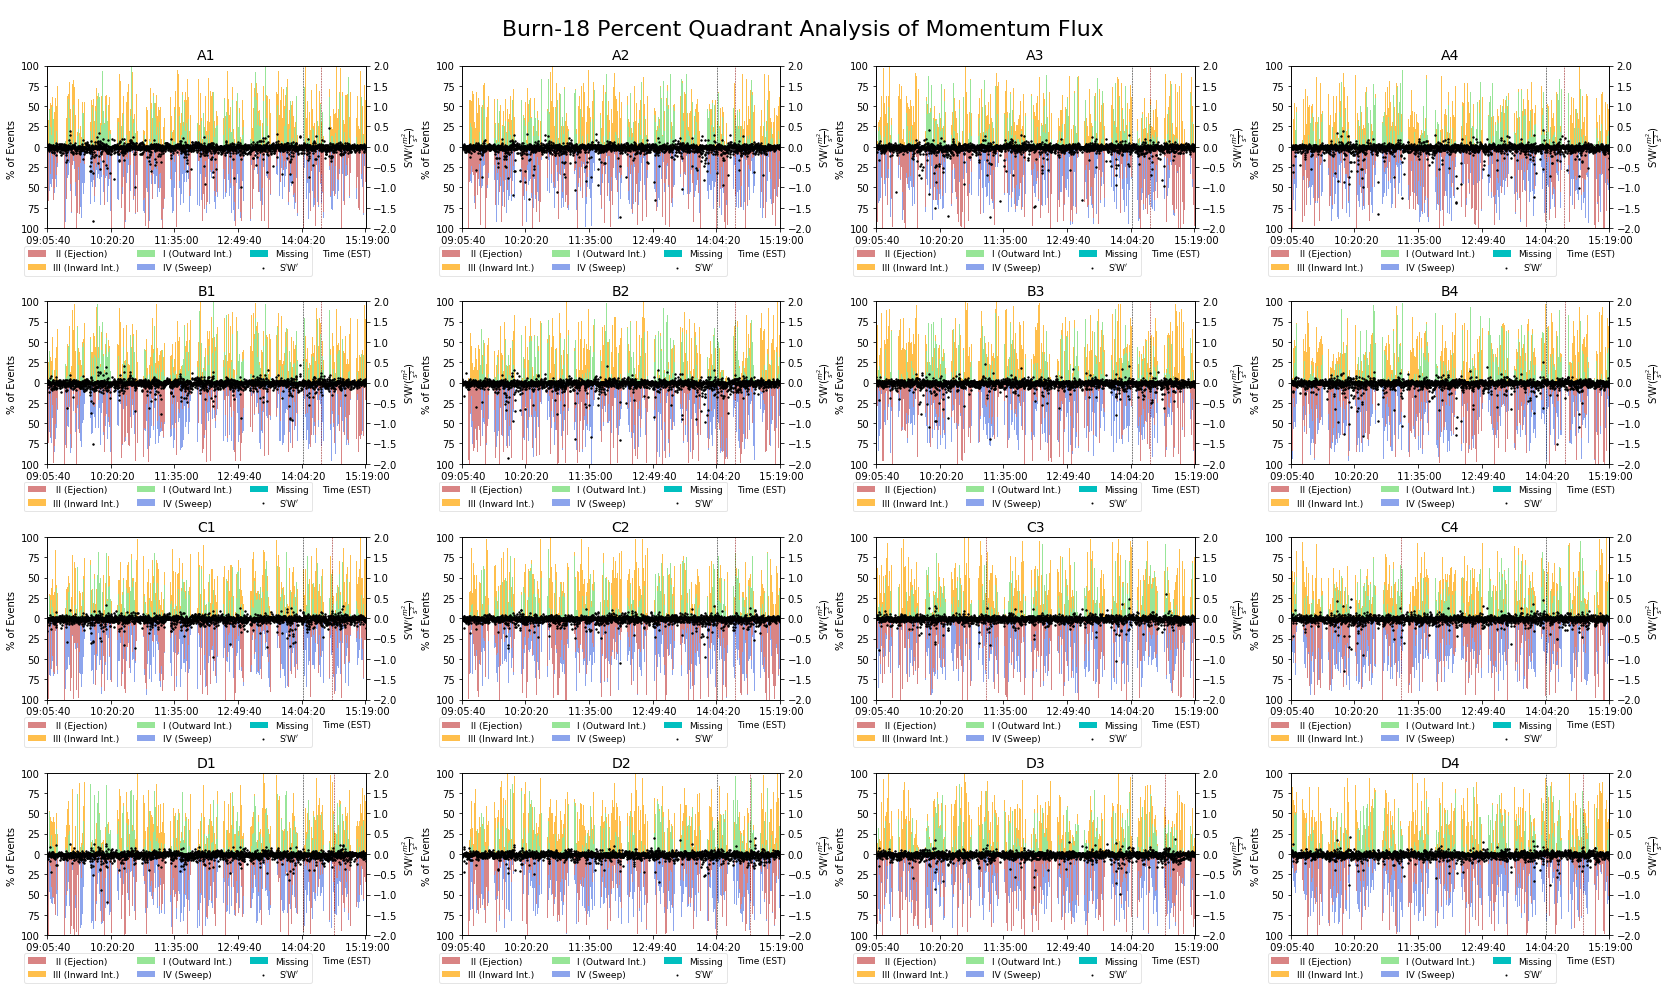

In [18]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-18/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,180000,"Burn-18")

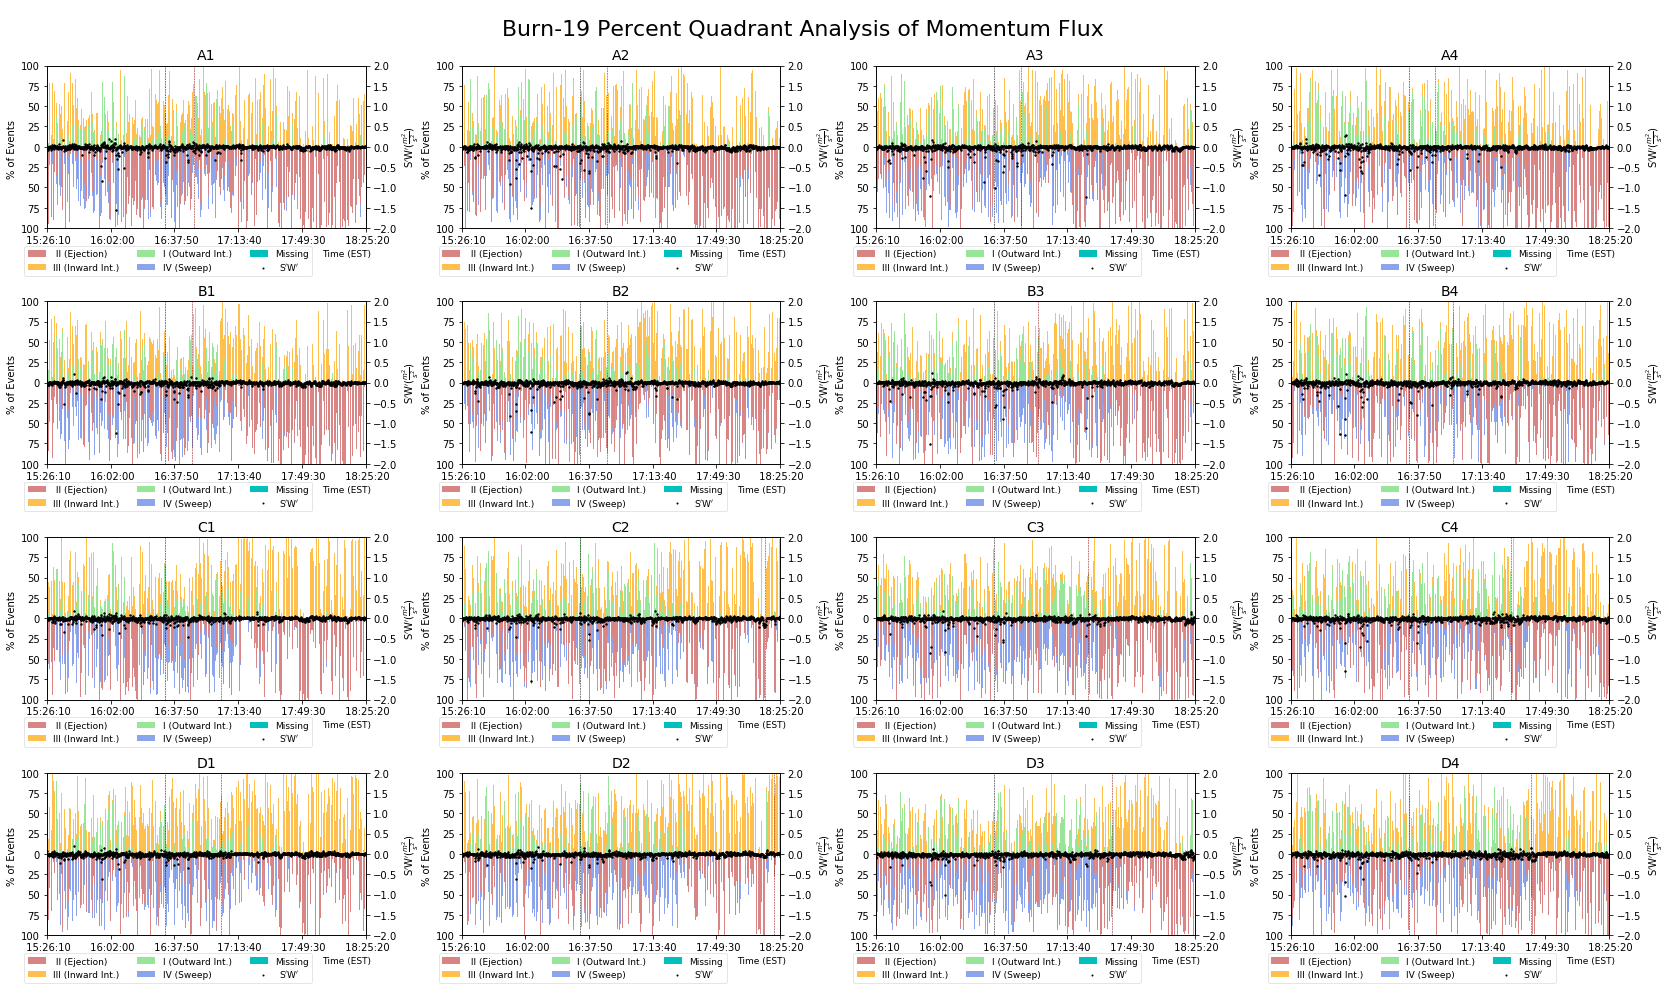

In [19]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-19/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,40000,"Burn-19")

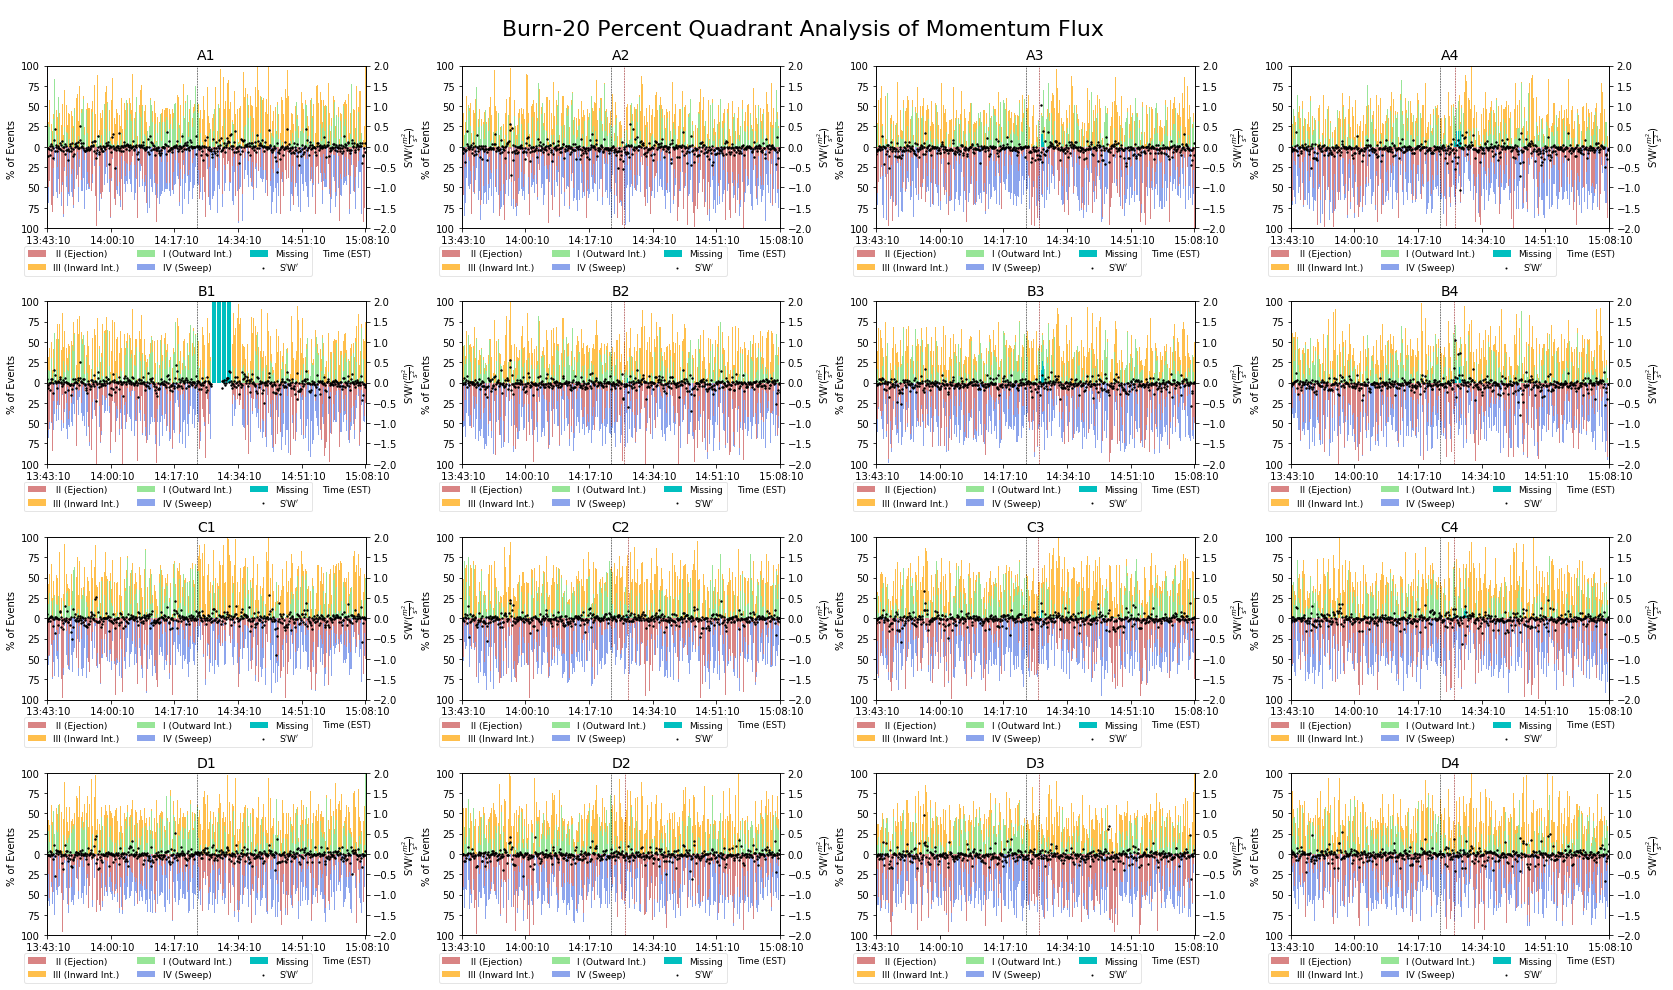

In [20]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-20/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,24000,"Burn-20")

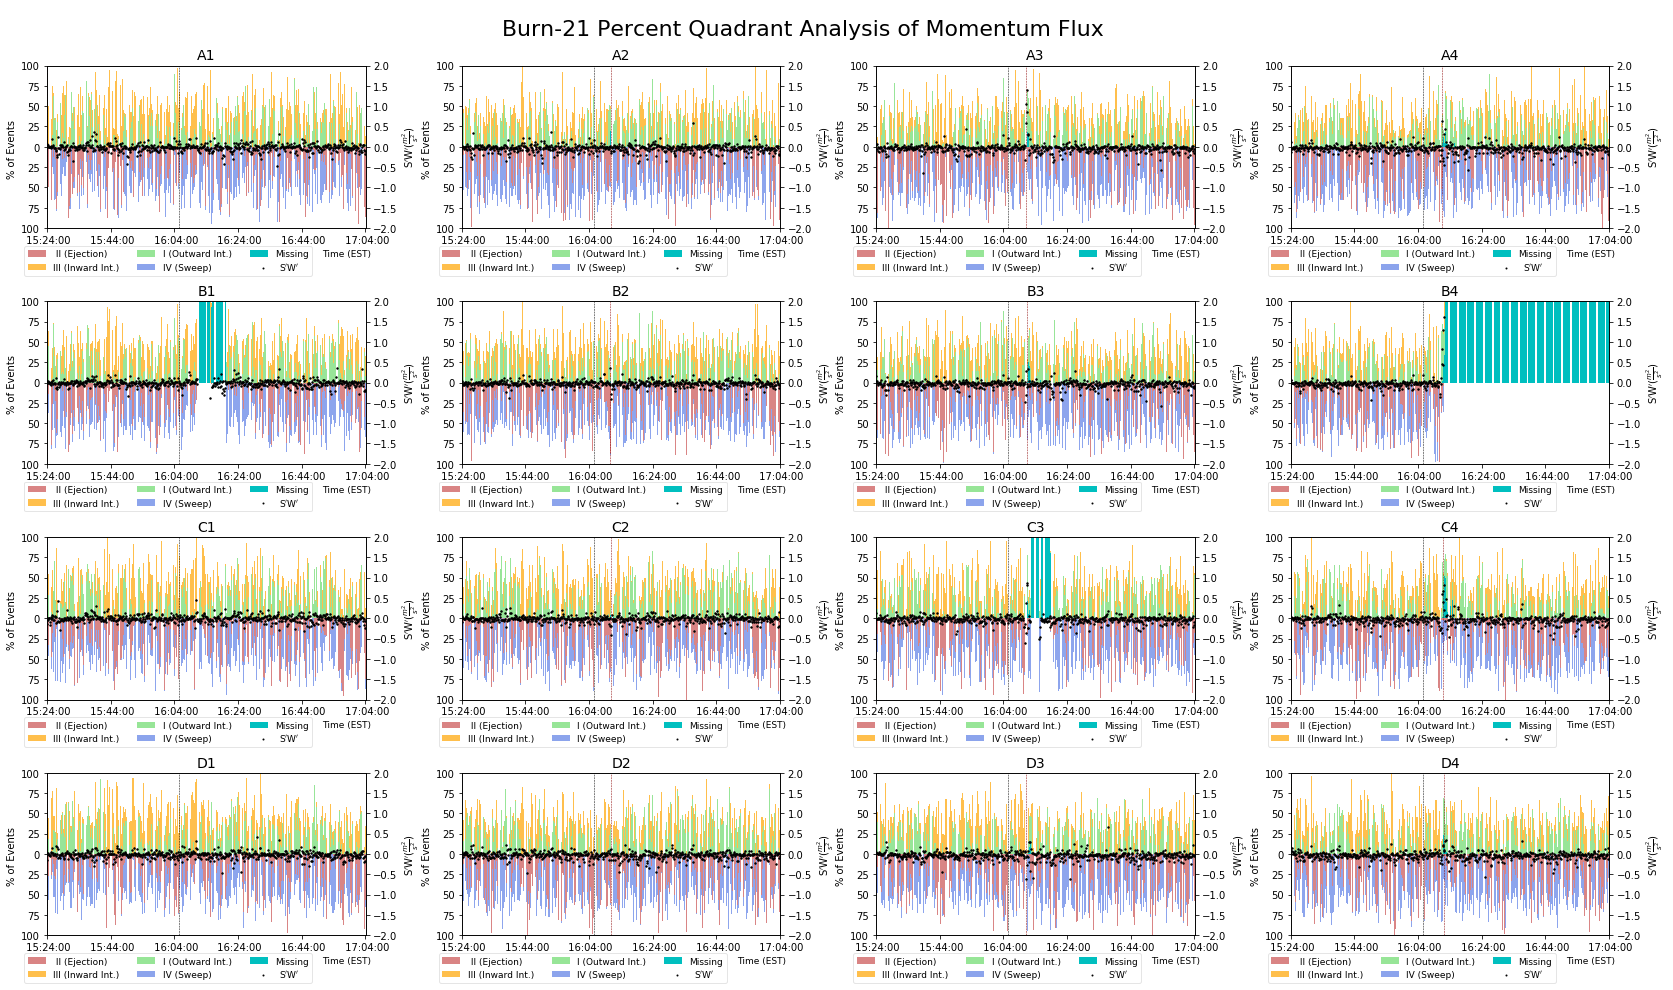

In [21]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-21/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,25000,"Burn-21")

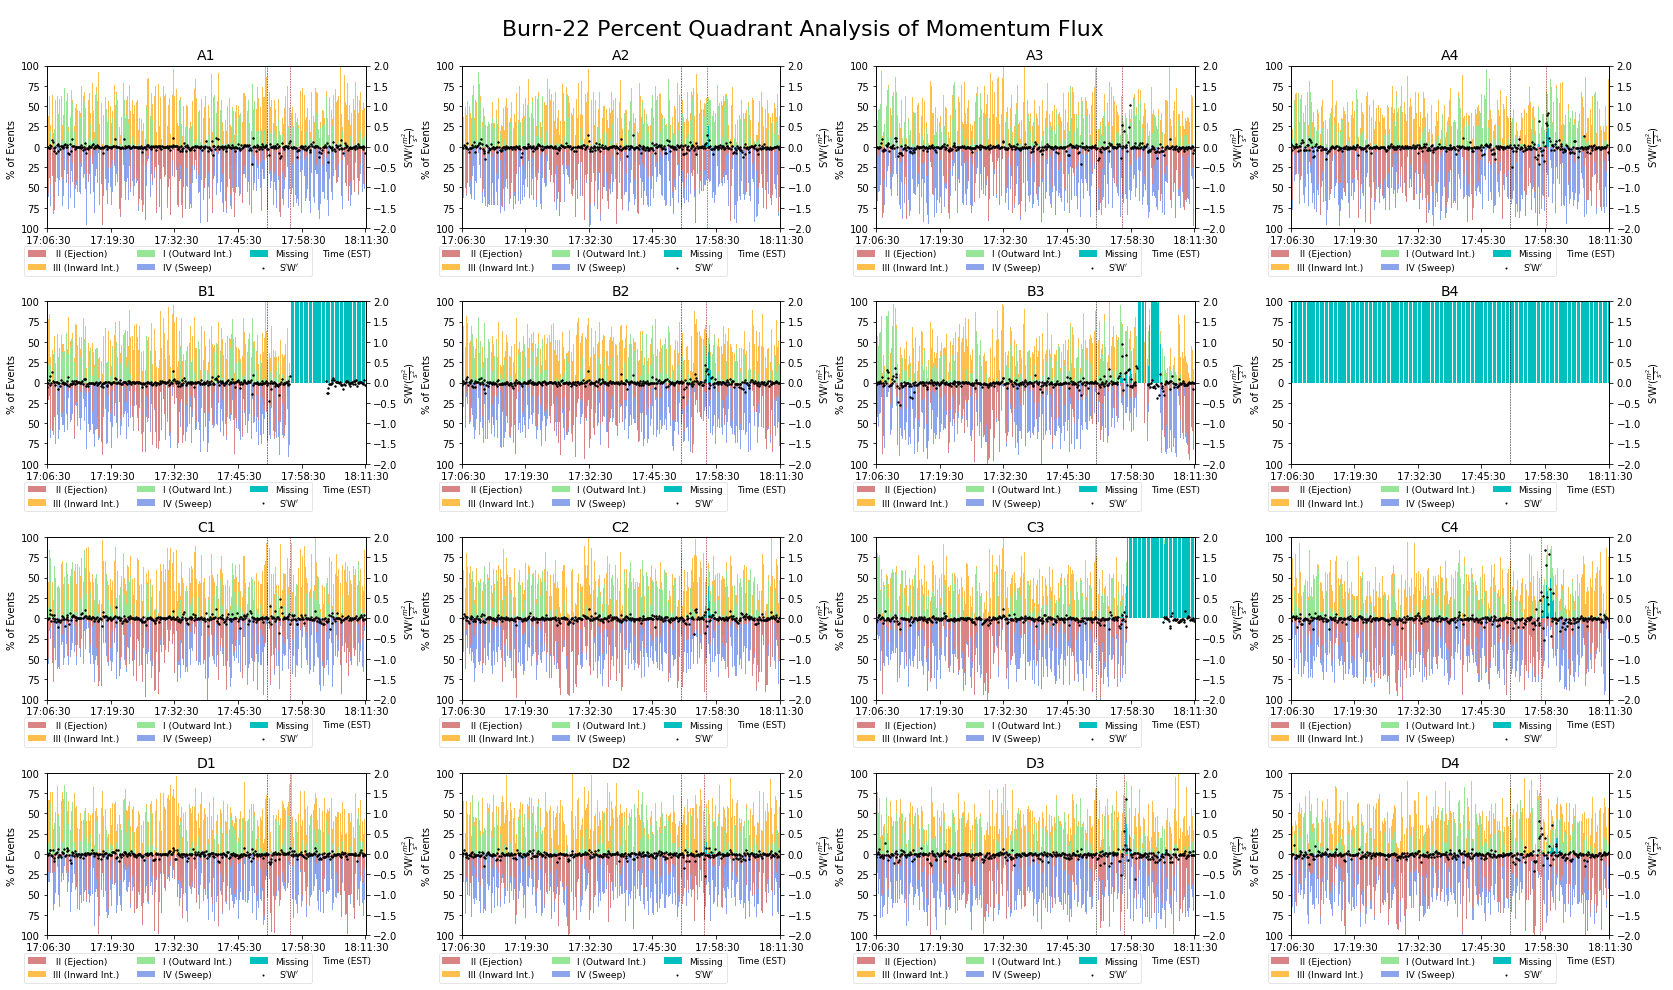

In [22]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-22/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,27000,"Burn-22")

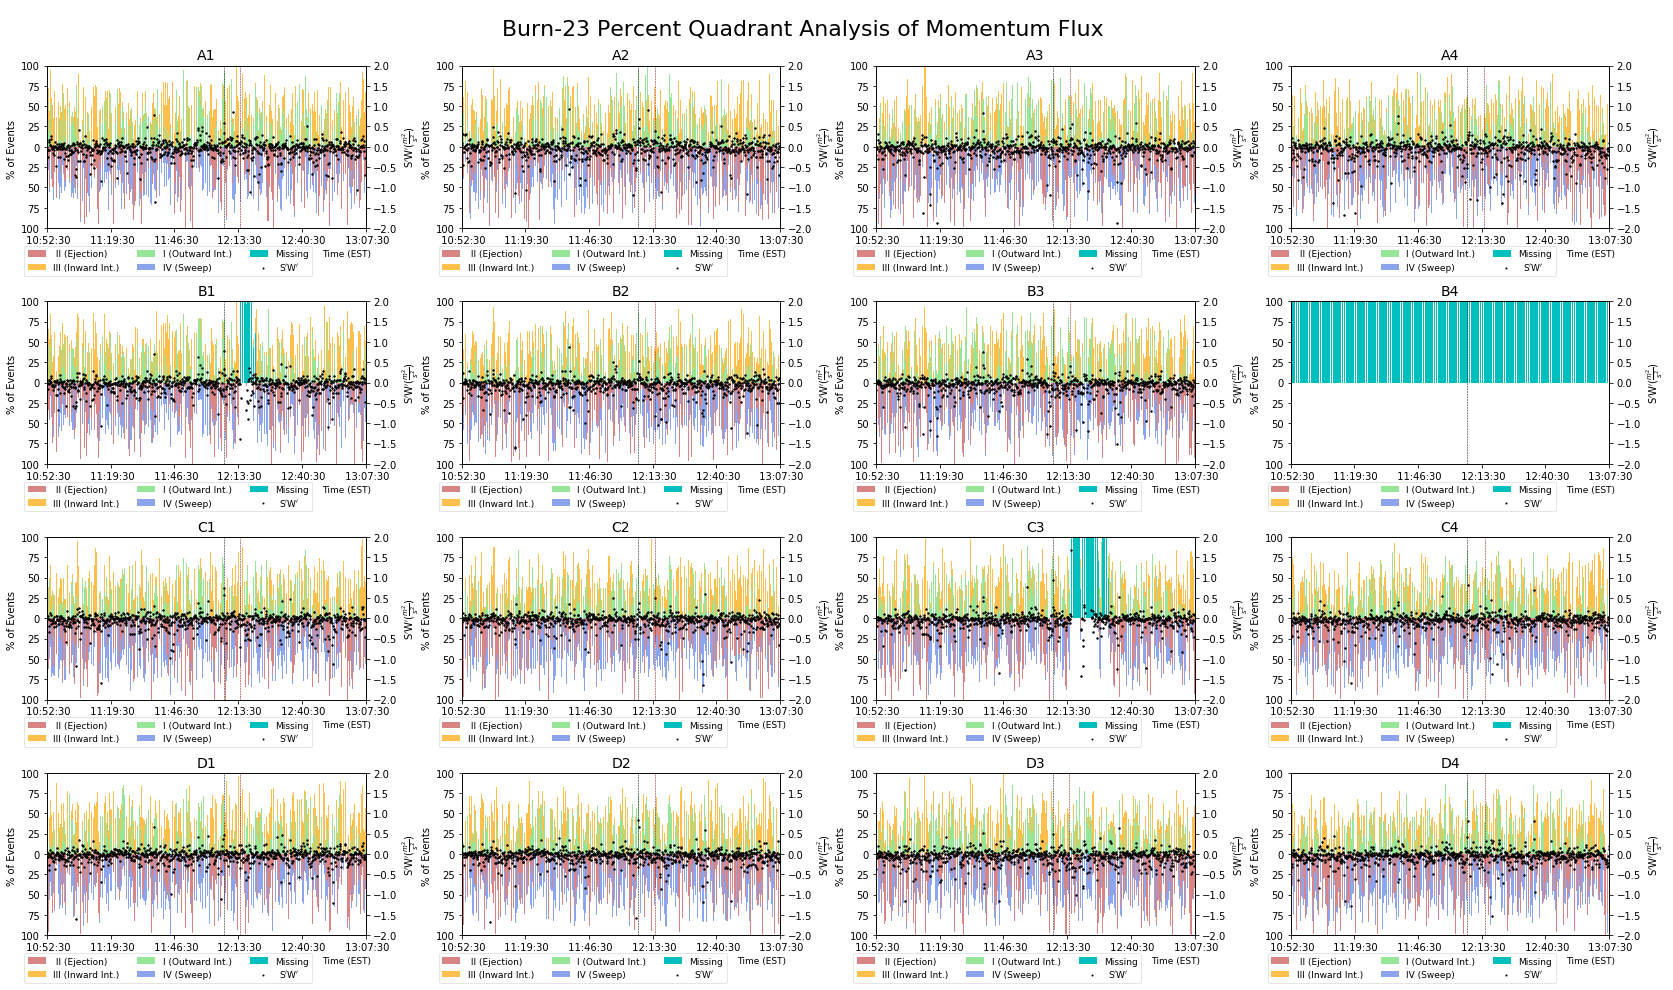

In [23]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-23/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,45000,"Burn-23")

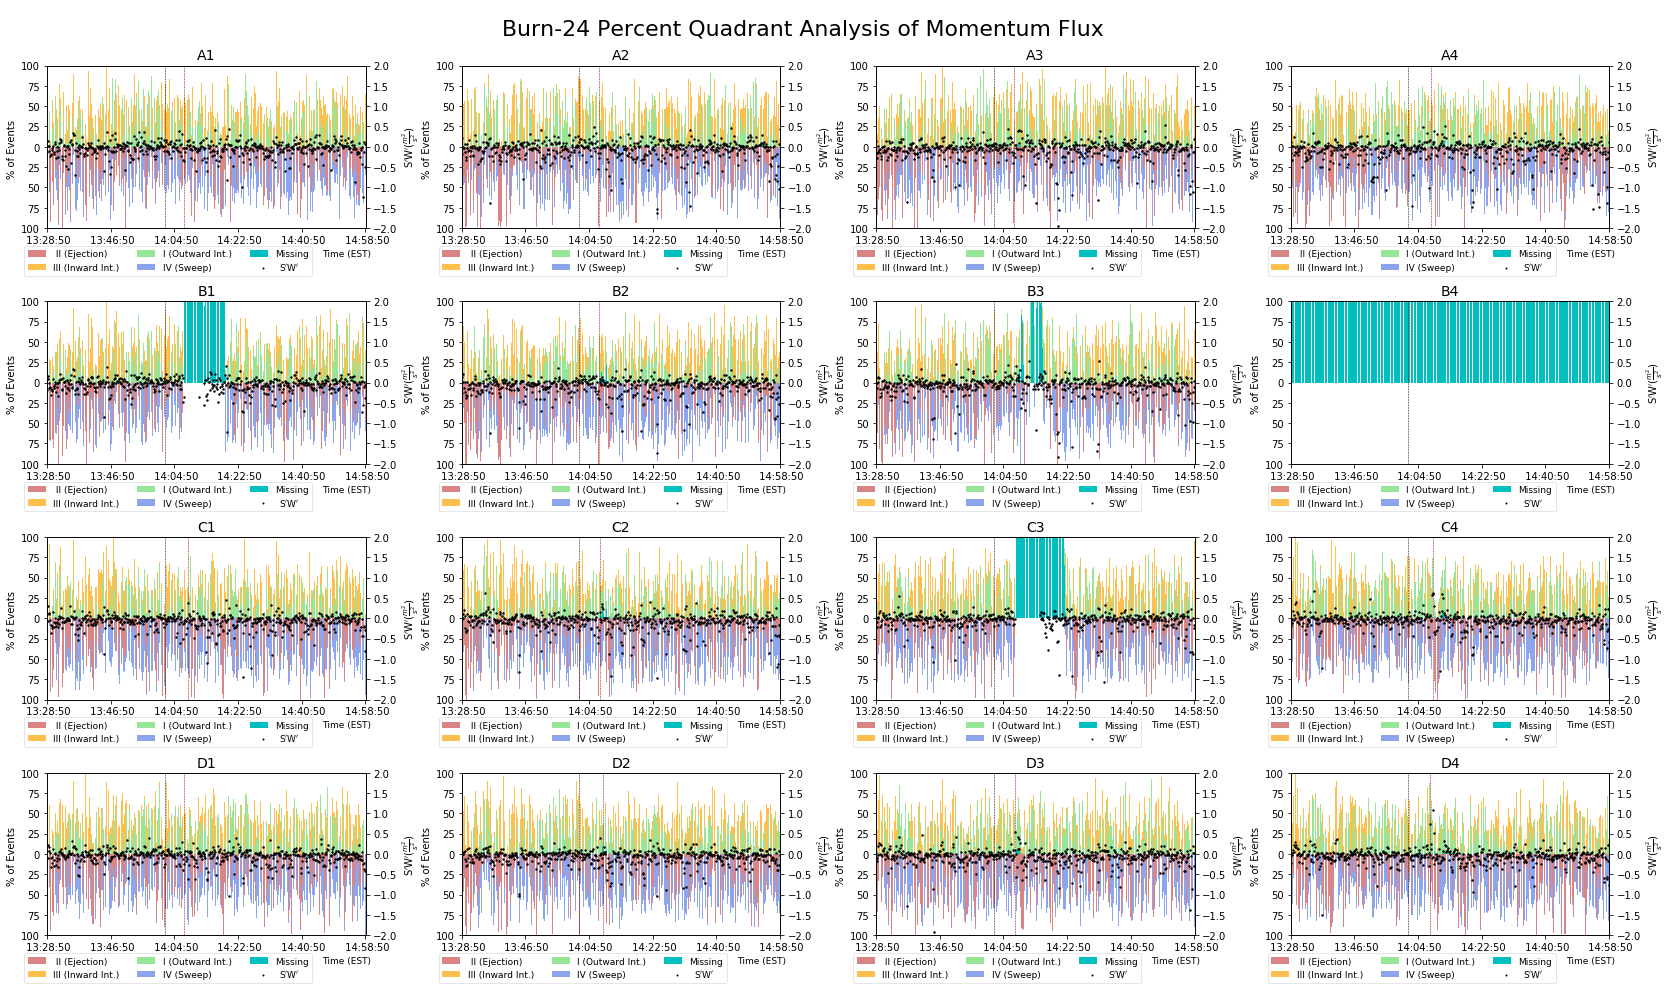

In [24]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-24/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,20000,"Burn-24")

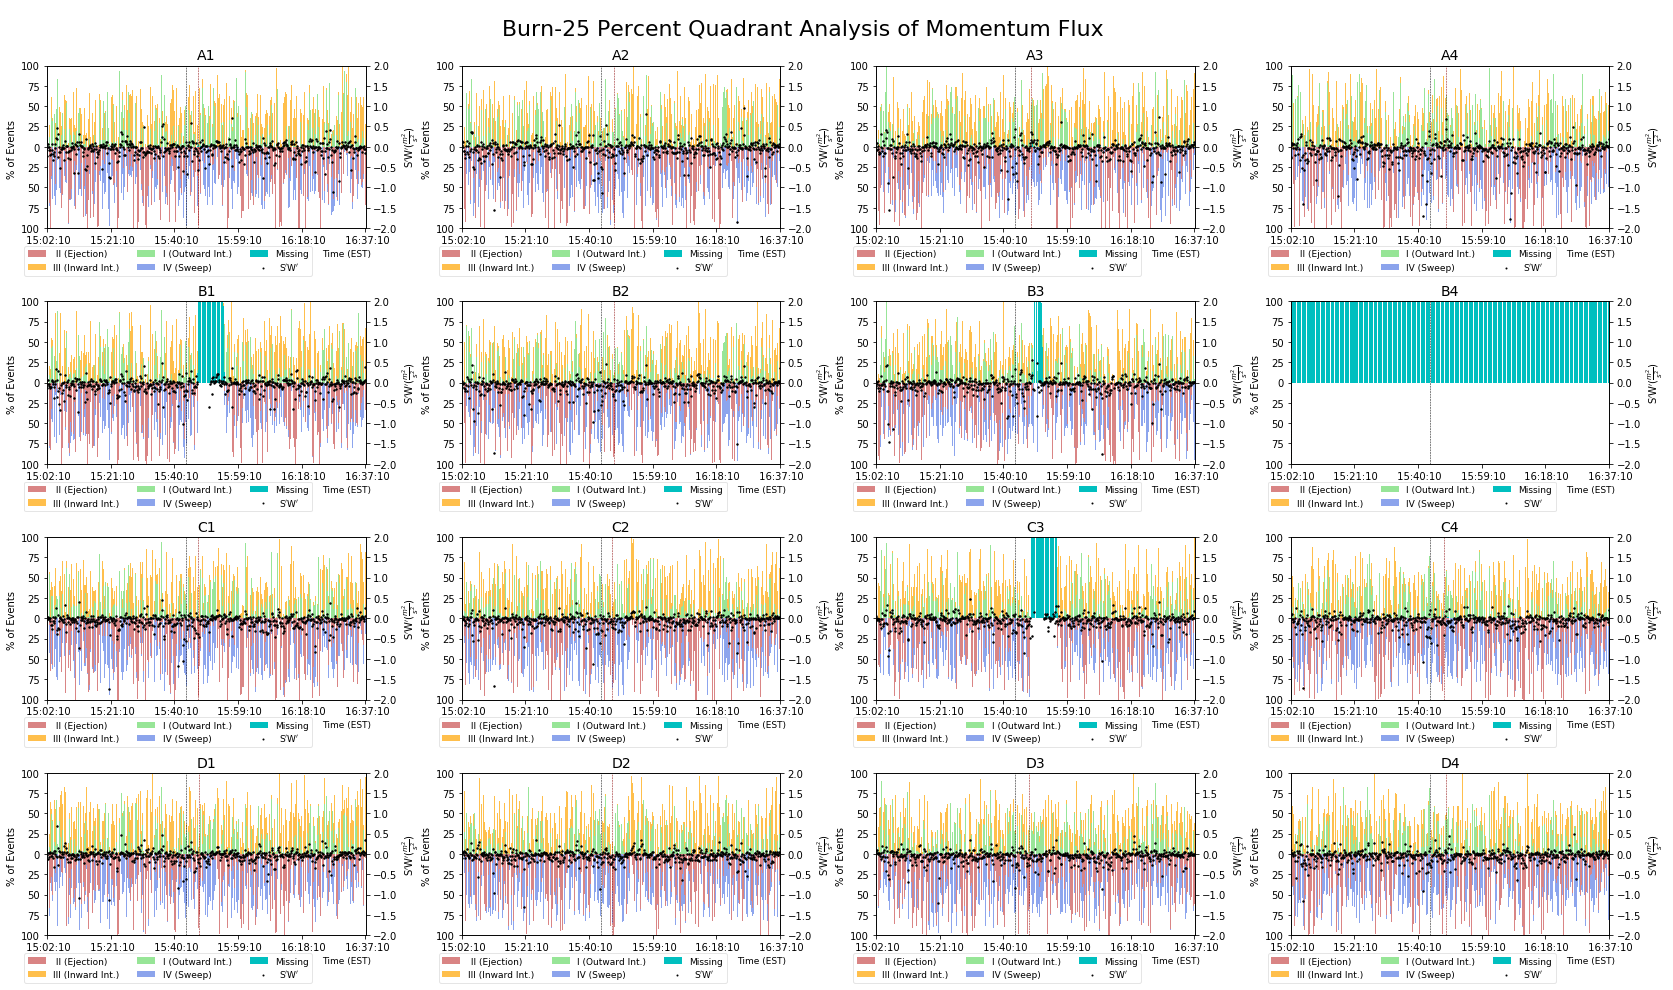

In [25]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-25/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,25000,"Burn-25")

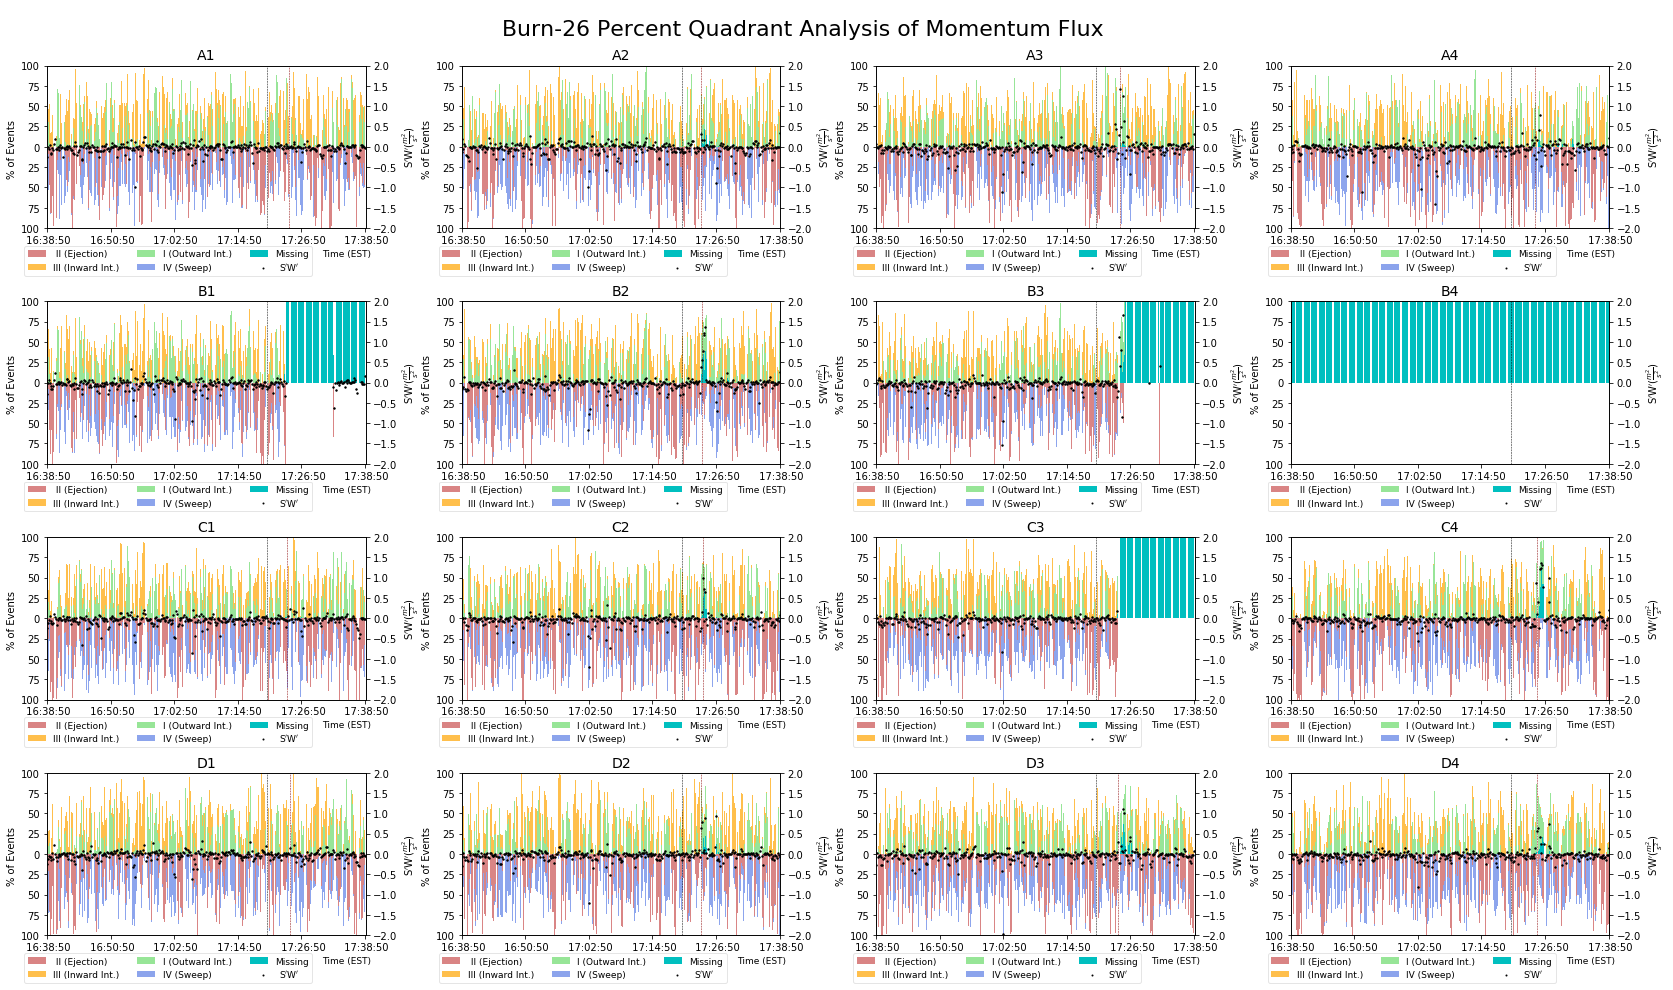

In [26]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-26/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,25000,"Burn-26")

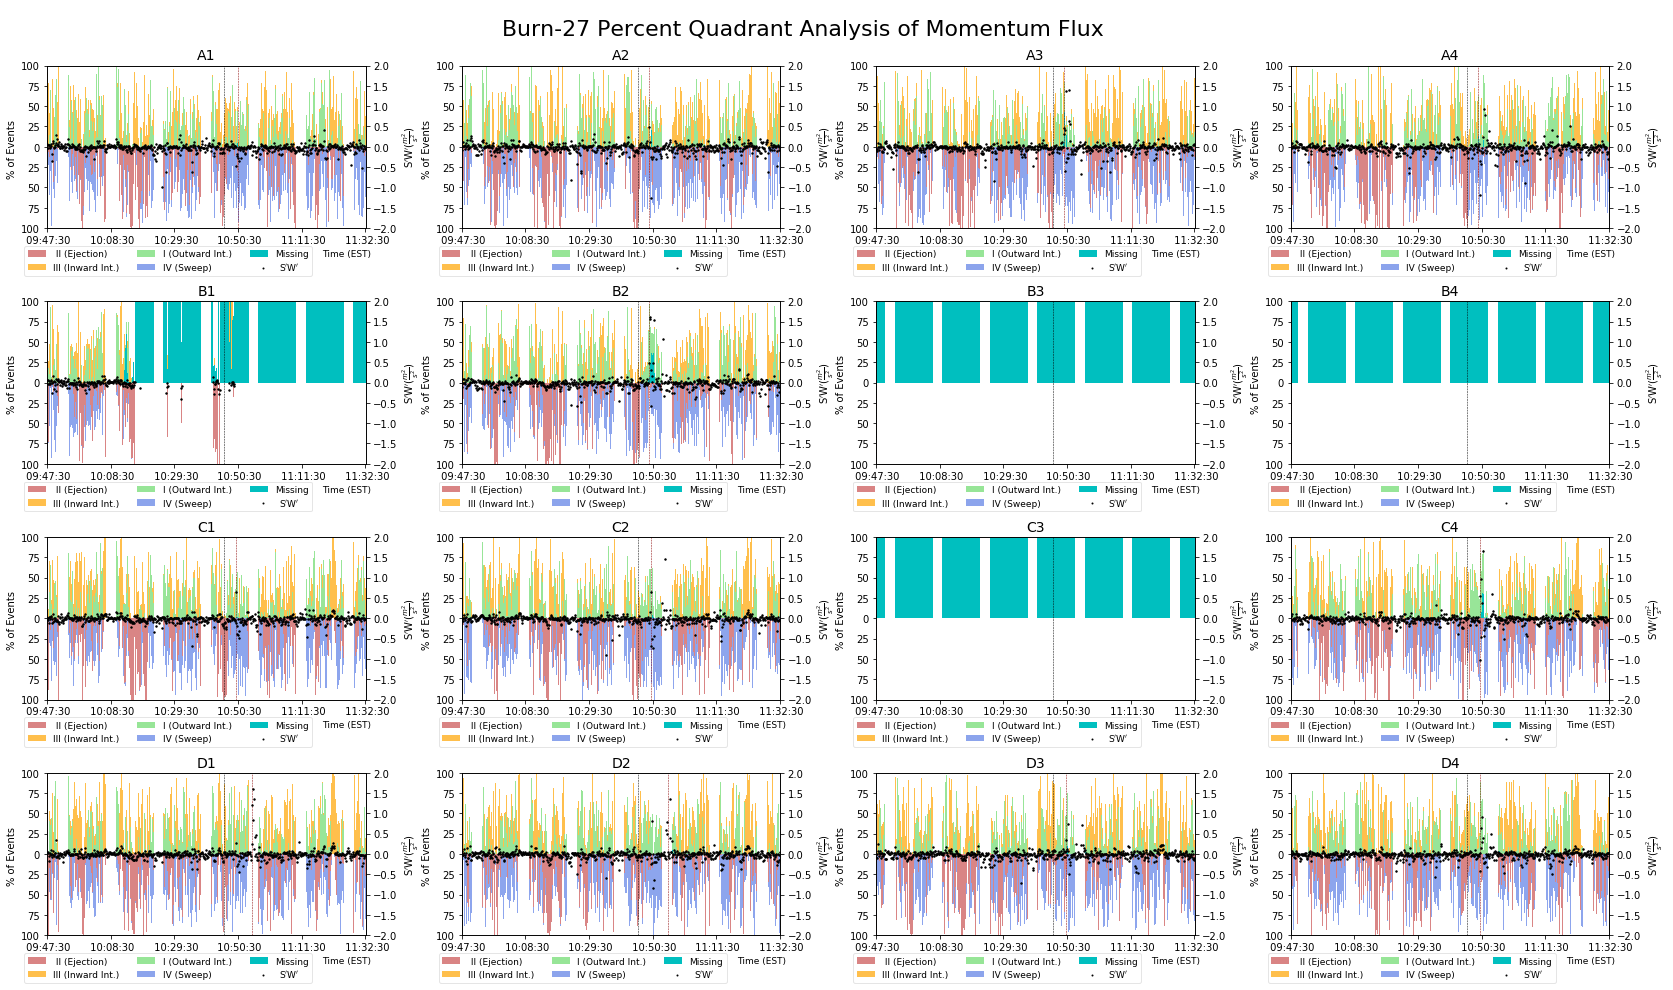

In [27]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-27/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,35000,"Burn-27")

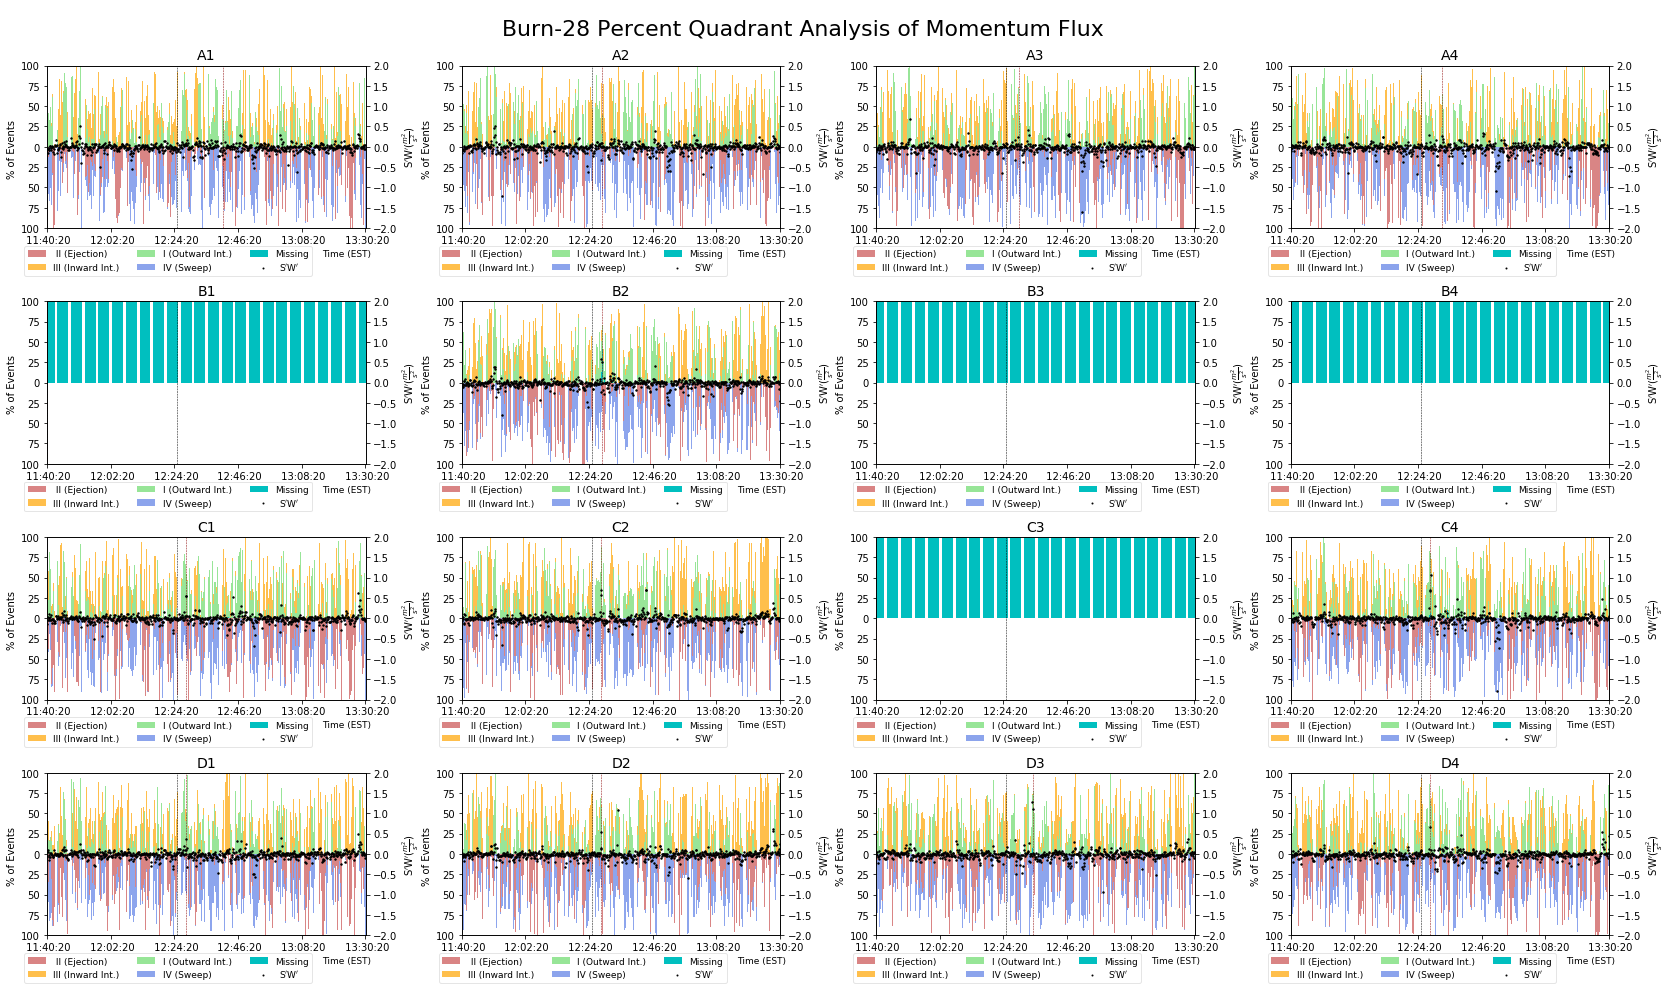

In [28]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-28/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,27000,"Burn-28")

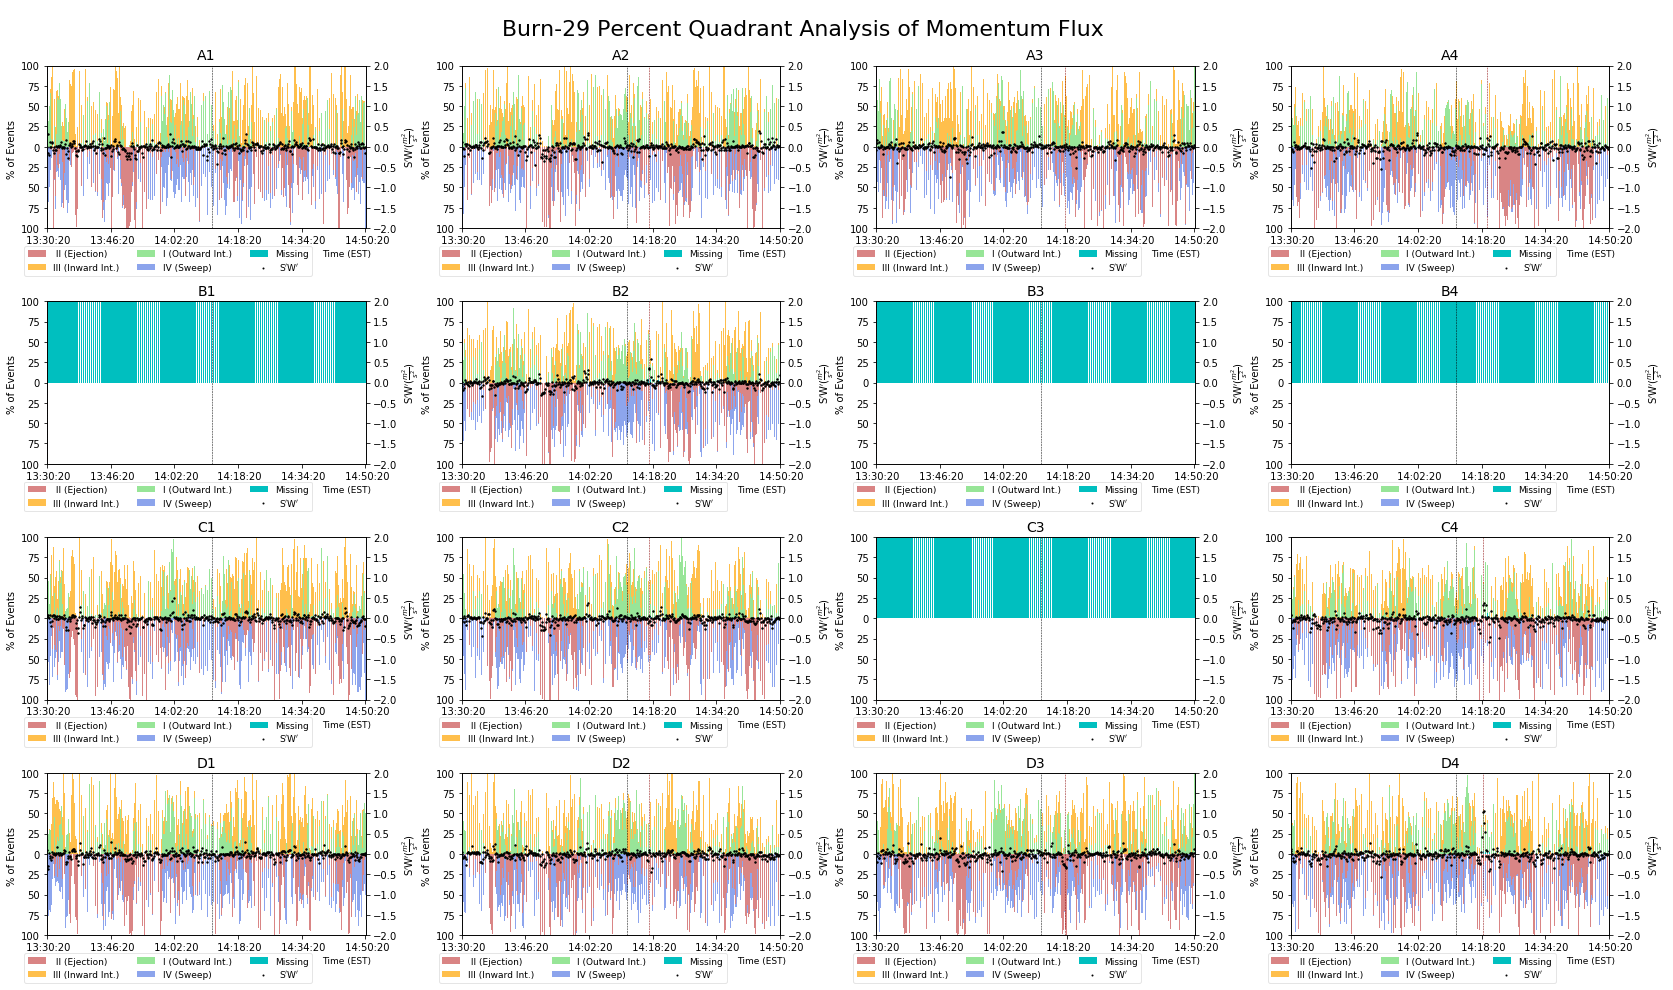

In [29]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-29/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,25000,"Burn-29")

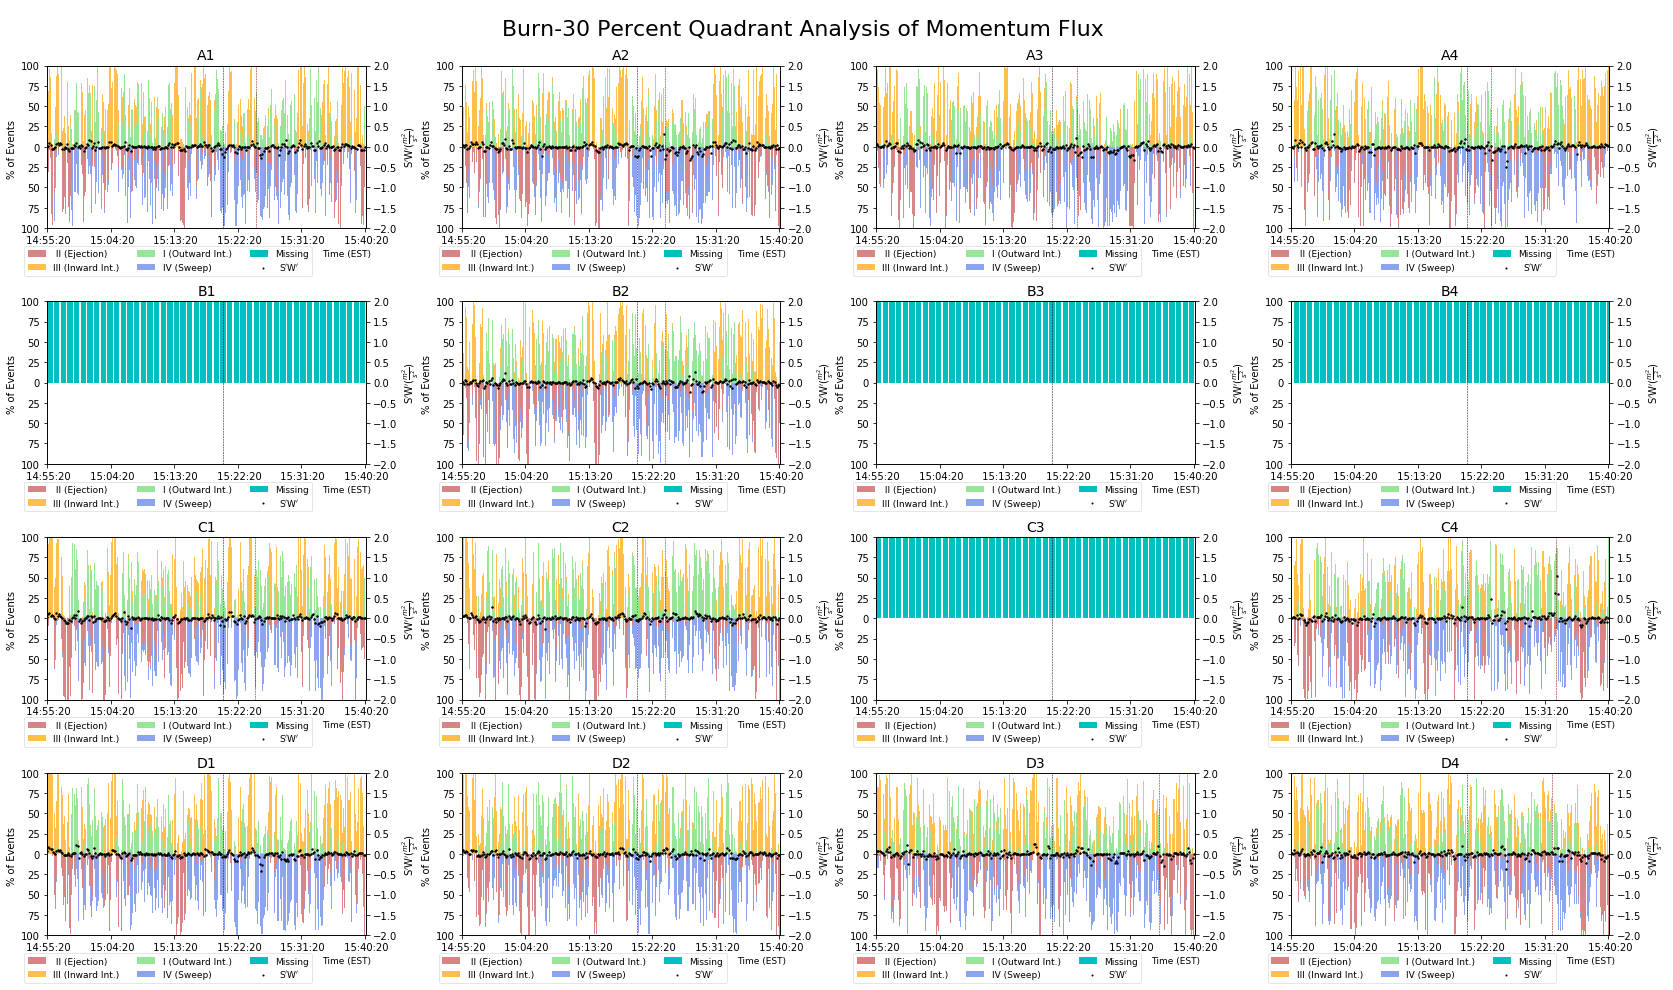

In [30]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-30/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,15000,"Burn-30")

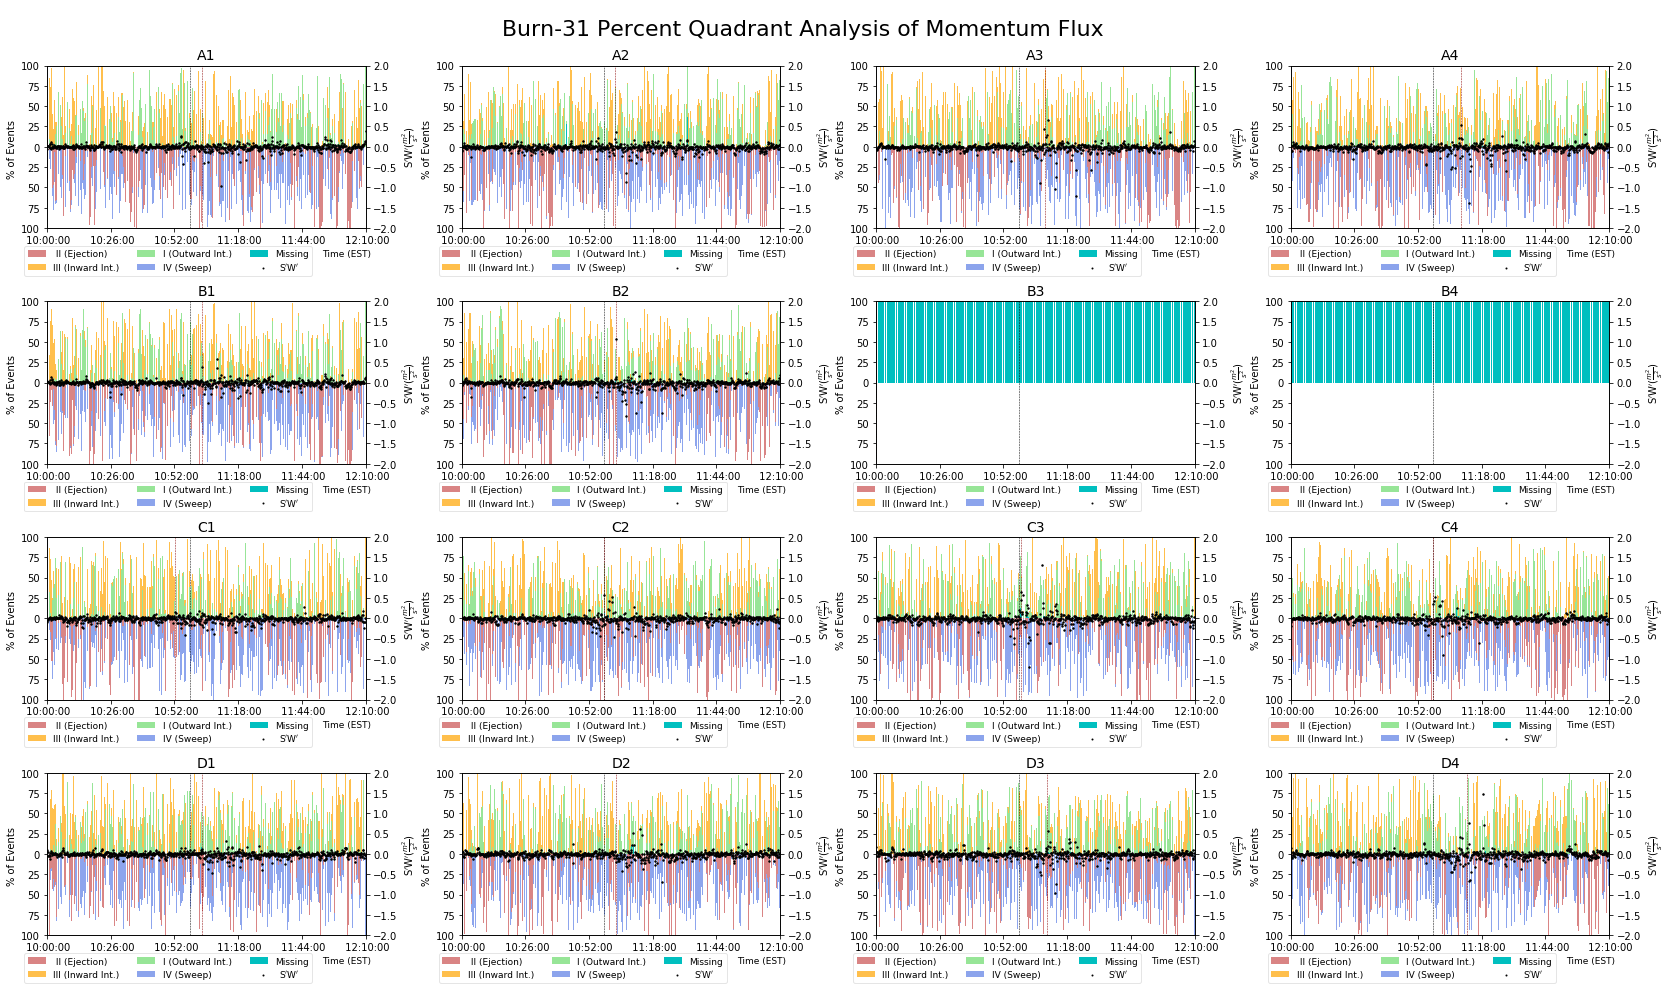

In [31]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-31/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,35000,"Burn-31")

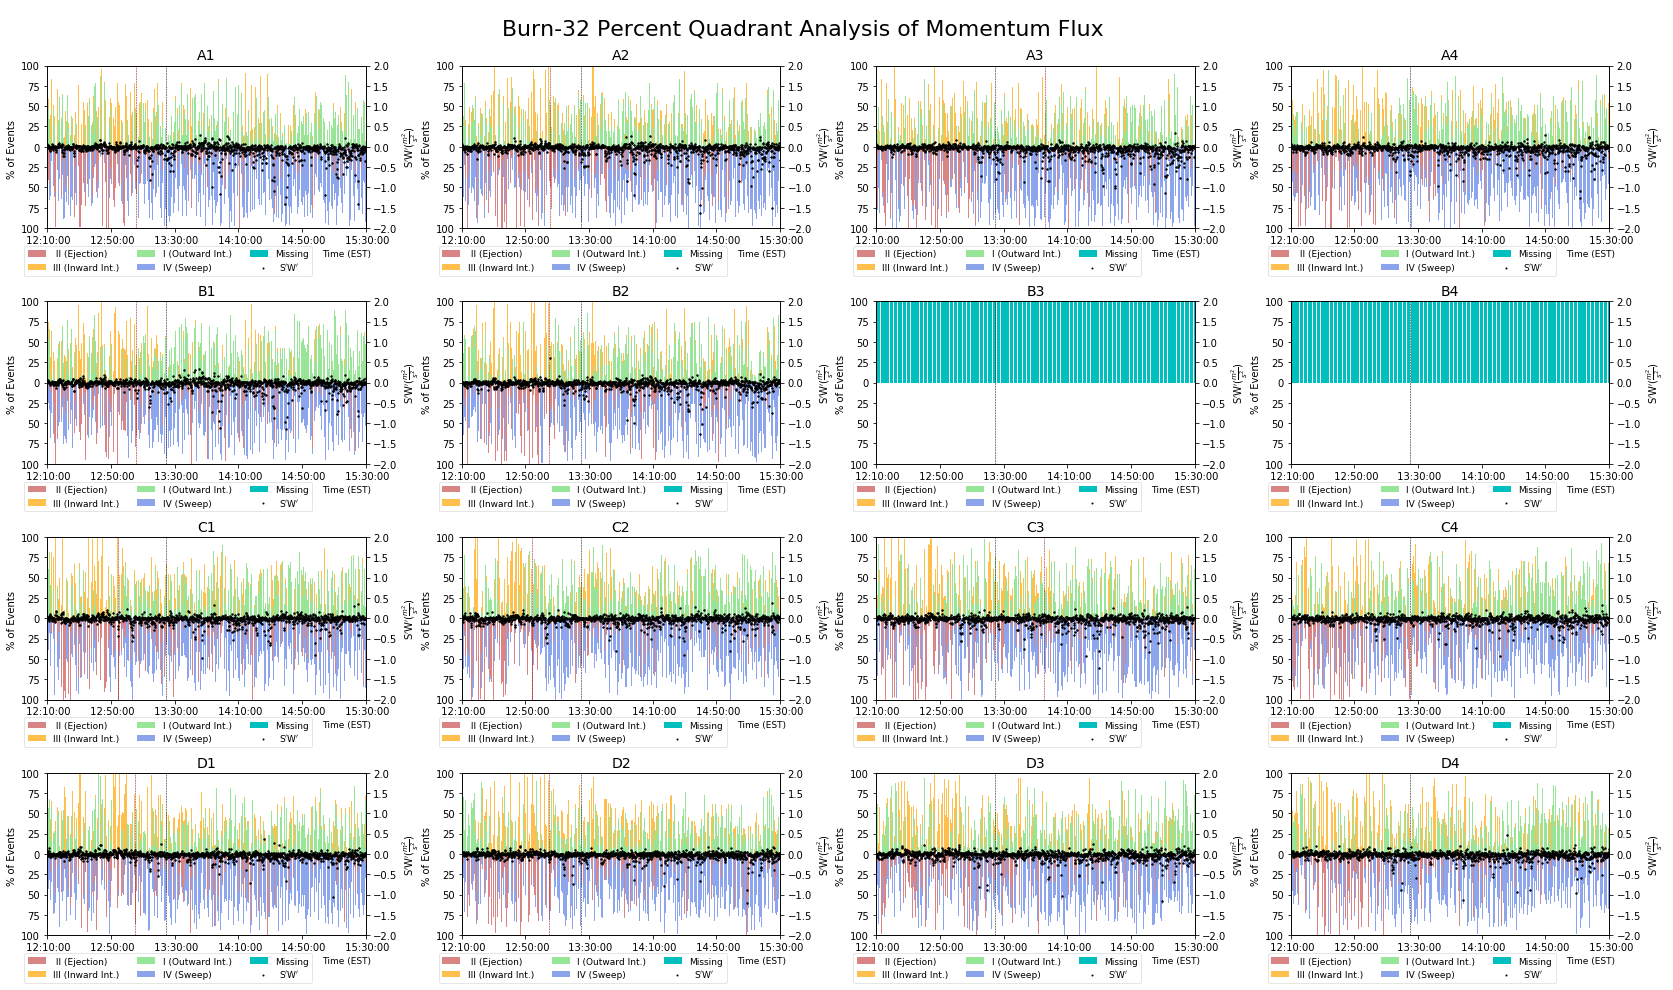

In [32]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-32/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,45000,"Burn-32")

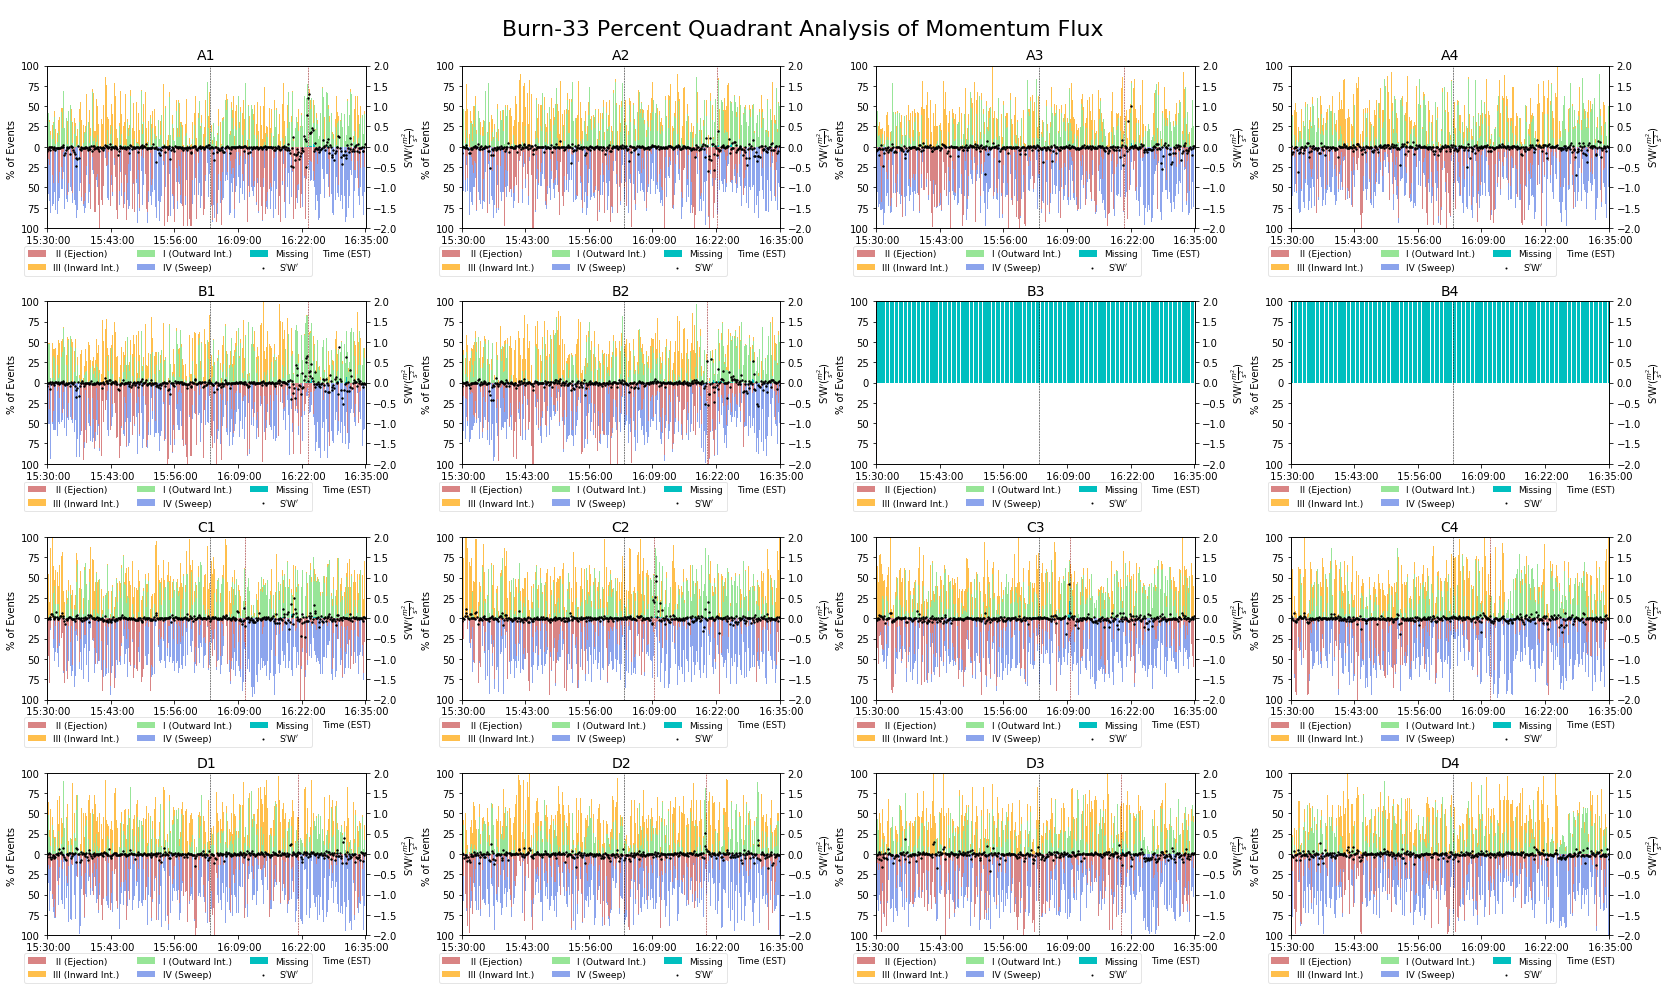

In [33]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-33/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,20000,"Burn-33")

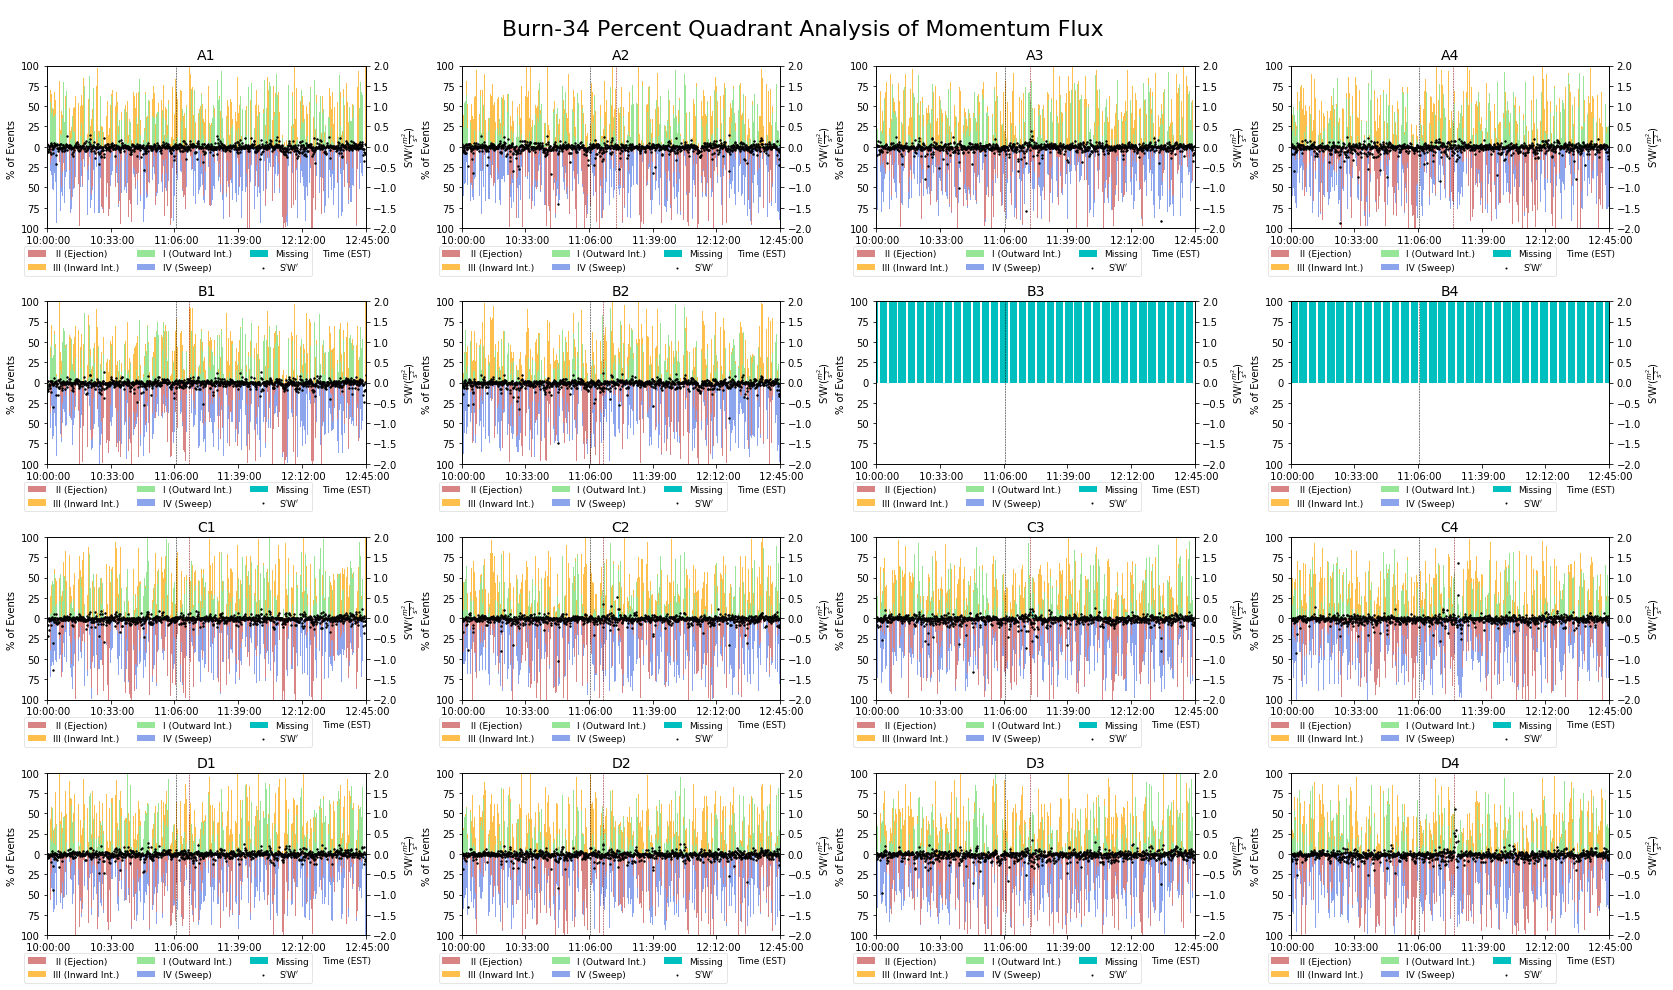

In [34]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-34/sonics/" #79 location
#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,40000,"Burn-34")